In [6]:
#from wakemodel import *
#from topdown import *
import copy
import numpy as np
import matplotlib.pyplot as plt
#from jensenmodel import JensenModel
import scipy.spatial as spt
import shapely.geometry as geom
import scipy.optimize as opt
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from netCDF4 import Dataset
#from coupledmodel import coupledmodel
import pandas as pd
import math
from sympy import symbols, Eq, solve
from floris import FlorisModel
from floris.turbine_library import build_cosine_loss_turbine_dict
from floris import  TimeSeries
from floris.flow_visualization import visualize_heterogeneous_cut_plane
from floris.layout_visualization import plot_turbine_labels
import pyproj 
from pyproj import Proj, Transformer
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
import xarray as xr
from scipy.interpolate import interp1d
from glob import glob
import os


In [7]:
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 16
})

In [8]:
from pathlib import Path

BASE_DIR = Path.cwd() 

# Download the SCADA data

In [9]:
SCADAdata = xr.open_dataset(BASE_DIR/"KingPlainsData/KP_SCADA_phase3.nc")

In [10]:
print(SCADAdata)

<xarray.Dataset> Size: 6MB
Dimensions:           (num_turbines: 88, time: 1440, __resample_dim__: 1440)
Coordinates:
  * num_turbines      (num_turbines) <U21 7kB 'WIT_USKPL_SS001_WT001' ... 'WI...
  * time              (time) datetime64[ns] 12kB 2023-08-24 ... 2023-08-24T23...
  * __resample_dim__  (__resample_dim__) datetime64[ns] 12kB 2023-08-24 ... 2...
Data variables:
    Yaw Misalignment  (time, num_turbines) float64 1MB ...
    Curtailment       (time, num_turbines) float64 1MB ...
    Wind Speed        (time, num_turbines) float64 1MB ...
    Power             (time, num_turbines) float64 1MB ...
    Yaw               (__resample_dim__, num_turbines) float64 1MB ...
    Wind Direction    (__resample_dim__, num_turbines) float64 1MB ...


In [11]:
print(SCADAdata['time'])
print(SCADAdata['__resample_dim__'])


<xarray.DataArray 'time' (time: 1440)> Size: 12kB
array(['2023-08-24T00:00:00.000000000', '2023-08-24T00:01:00.000000000',
       '2023-08-24T00:02:00.000000000', ..., '2023-08-24T23:57:00.000000000',
       '2023-08-24T23:58:00.000000000', '2023-08-24T23:59:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 12kB 2023-08-24 ... 2023-08-24T23:59:00
<xarray.DataArray '__resample_dim__' (__resample_dim__: 1440)> Size: 12kB
array(['2023-08-24T00:00:00.000000000', '2023-08-24T00:01:00.000000000',
       '2023-08-24T00:02:00.000000000', ..., '2023-08-24T23:57:00.000000000',
       '2023-08-24T23:58:00.000000000', '2023-08-24T23:59:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * __resample_dim__  (__resample_dim__) datetime64[ns] 12kB 2023-08-24 ... 2...


In [12]:
time_equal = SCADAdata['time'].values == SCADAdata['__resample_dim__'].values

print(f"All equal? {time_equal.all()}")
print(f"Number of unequal entries: {np.sum(~time_equal)}")
print(f"Number of entries: {np.shape(SCADAdata['time'])}")
print(f"Number of entries: {np.shape(SCADAdata['__resample_dim__'])}")


All equal? True
Number of unequal entries: 0
Number of entries: (1440,)
Number of entries: (1440,)


In [13]:
# Extract SCADA data
nc_file = Dataset(BASE_DIR/"KingPlainsData/KP_SCADA_phase3.nc", mode="r")


# Extract variable names
variable_names = list(nc_file.variables.keys())

# Print the variable names (just for verification)
print(variable_names)

['num_turbines', 'time', 'Yaw Misalignment', 'Curtailment', 'Wind Speed', 'Power', '__resample_dim__', 'Yaw', 'Wind Direction']


In [14]:

# Ensure time is datetime (just in case)
SCADAdata['time'] = pd.to_datetime(SCADAdata['time'])




In [15]:

SCADAdata['not_curtailed']=SCADAdata["Curtailment"]== 0
SCADAdata['not_misaligned'] = abs(SCADAdata["Yaw Misalignment"]) < 5
valid_power = ~np.isnan(SCADAdata['Power'])



In [16]:
SCADAdata.where((SCADAdata['not_curtailed'] == True) & 
                         (SCADAdata['not_misaligned'] == True), drop=False)

<xarray.Dataset> Size: 3GB
Dimensions:           (time: 1440, num_turbines: 88, __resample_dim__: 1440)
Coordinates:
  * num_turbines      (num_turbines) <U21 7kB 'WIT_USKPL_SS001_WT001' ... 'WI...
  * time              (time) datetime64[ns] 12kB 2023-08-24 ... 2023-08-24T23...
  * __resample_dim__  (__resample_dim__) datetime64[ns] 12kB 2023-08-24 ... 2...
Data variables:
    Yaw Misalignment  (time, num_turbines) float64 1MB nan 4.067 ... 4.818
    Curtailment       (time, num_turbines) float64 1MB nan 0.0 nan ... 0.0 0.0
    Wind Speed        (time, num_turbines) float64 1MB nan 5.521 ... 4.485 5.186
    Power             (time, num_turbines) float64 1MB nan 437.2 ... 249.8 372.3
    Yaw               (__resample_dim__, num_turbines, time) float64 1GB nan ...
    Wind Direction    (__resample_dim__, num_turbines, time) float64 1GB nan ...
    not_curtailed     (time, num_turbines) float64 1MB nan 1.0 nan ... 1.0 1.0
    not_misaligned    (time, num_turbines) float64 1MB nan 1.0 nan ... 1.0 1.0

In [17]:
SCADAdata[['time', 'num_turbines','Wind Speed' ,'Wind Direction','Power','__resample_dim__']].head(20)


<xarray.Dataset> Size: 12kB
Dimensions:           (time: 20, num_turbines: 20, __resample_dim__: 20)
Coordinates:
  * time              (time) datetime64[ns] 160B 2023-08-24 ... 2023-08-24T00...
  * num_turbines      (num_turbines) <U21 2kB 'WIT_USKPL_SS001_WT001' ... 'WI...
  * __resample_dim__  (__resample_dim__) datetime64[ns] 160B 2023-08-24 ... 2...
Data variables:
    Wind Speed        (time, num_turbines) float64 3kB ...
    Wind Direction    (__resample_dim__, num_turbines) float64 3kB ...
    Power             (time, num_turbines) float64 3kB 482.5 437.2 ... 684.2

/var/folders/b0/mmm07nss4jzc_ktswk1mkzm00000gn/T/ipykernel_46675/918881420.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


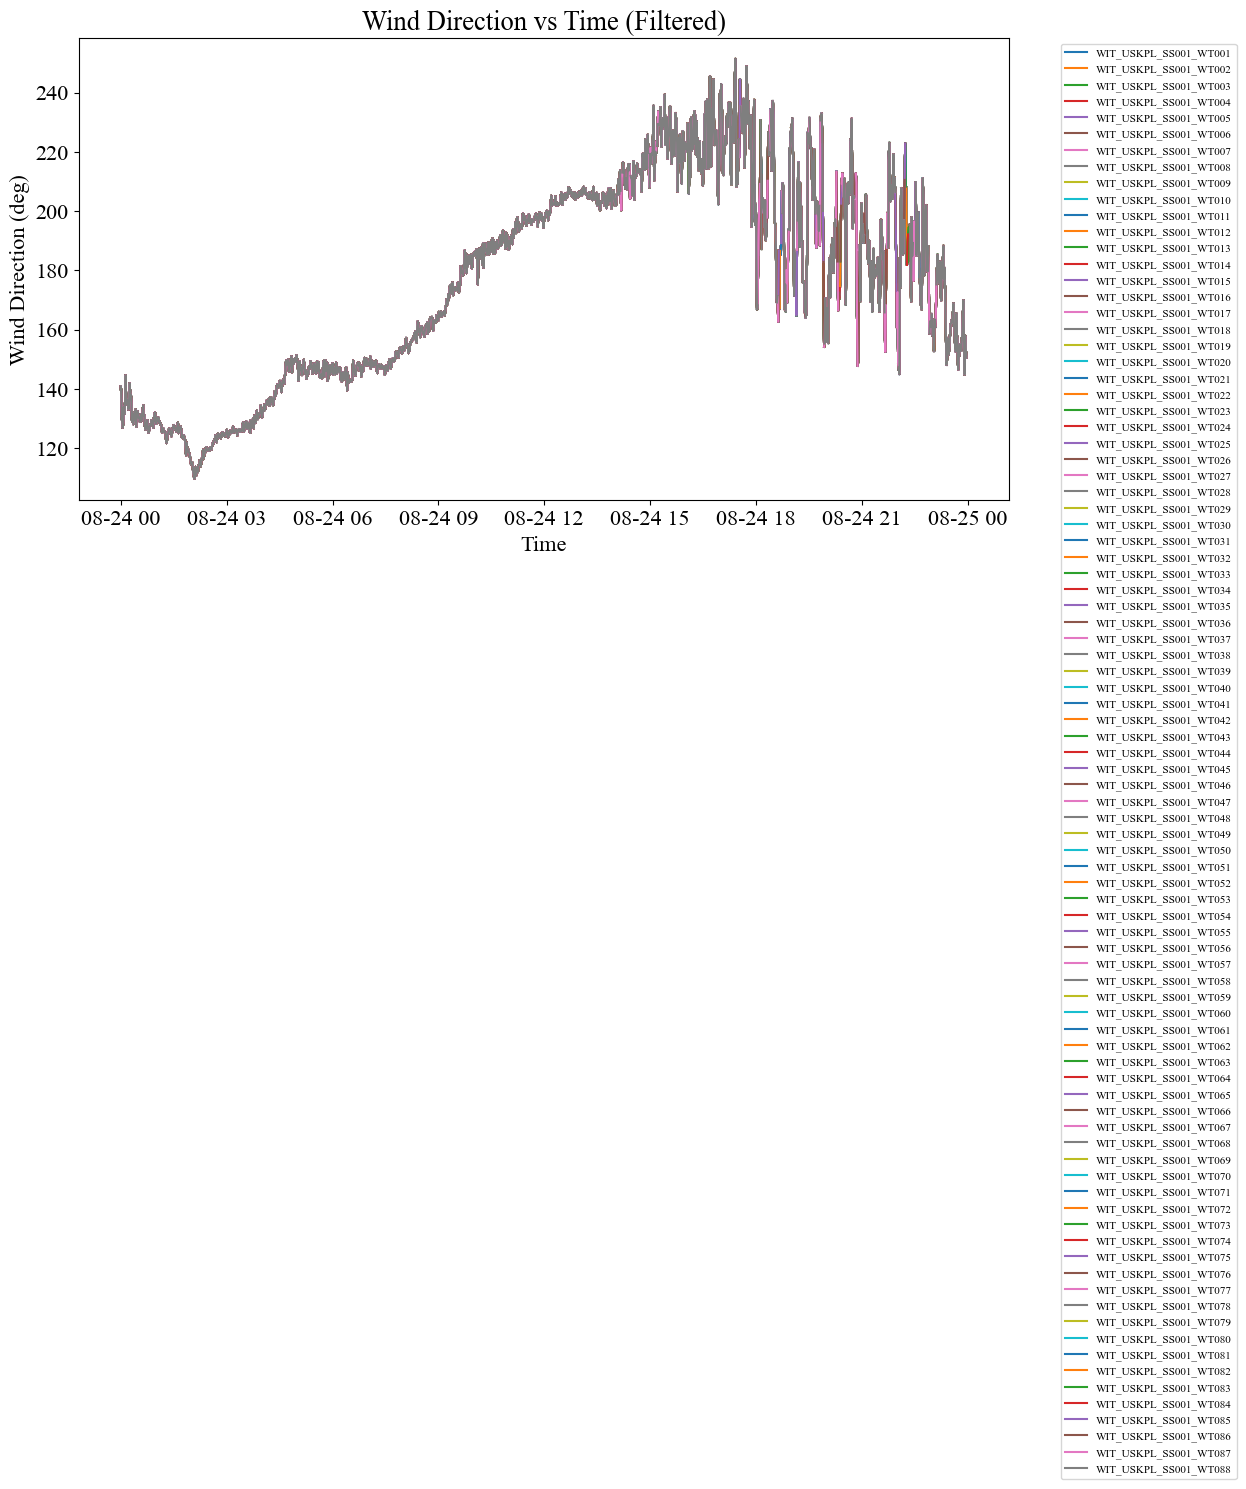

/var/folders/b0/mmm07nss4jzc_ktswk1mkzm00000gn/T/ipykernel_46675/918881420.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


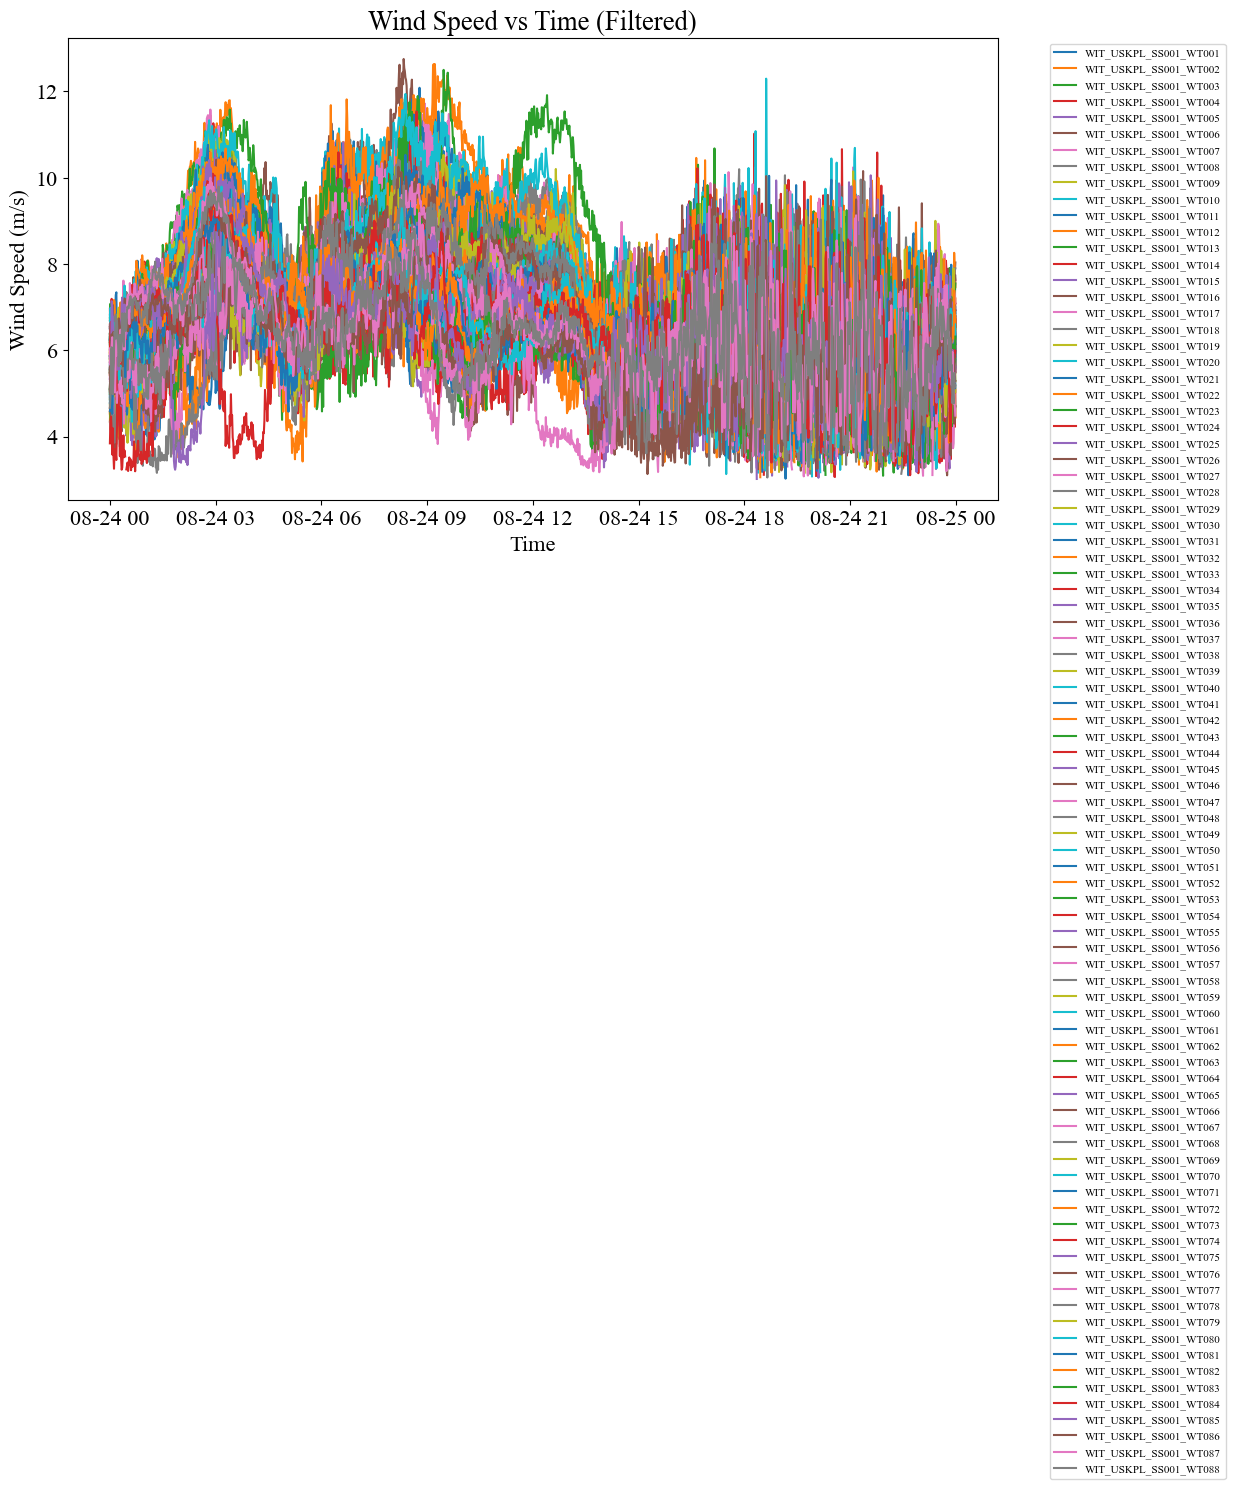

In [18]:
plt.figure(figsize=(12, 6))

for turbine in SCADAdata['num_turbines'].values:
    plt.plot(SCADAdata['time'], SCADAdata['Wind Direction'].sel(num_turbines=turbine), label=turbine)

plt.xlabel('Time')
plt.ylabel('Wind Direction (deg)')
plt.title('Wind Direction vs Time (Filtered)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))

for turbine in SCADAdata['num_turbines'].values:
    plt.plot(SCADAdata['time'], SCADAdata['Wind Speed'].sel(num_turbines=turbine), label=turbine)

plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed vs Time (Filtered)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

# Download sonic anemometer data

In [19]:

A1_sonic = xr.open_dataset(BASE_DIR/"KingPlainsData/Sonic_anemometers/A1_sonic.nc")

A5_sonic = xr.open_dataset(BASE_DIR/"KingPlainsData/Sonic_anemometers/A5_sonic.nc")
A2_sonic = xr.open_dataset(BASE_DIR/"KingPlainsData/Sonic_anemometers/A2_sonic.nc")




In [20]:
variable_names = list(A1_sonic.variables.keys())

# Print the variable names (just for verification)
print(variable_names)

['WS', 'WD', 'u', 'v', 'w', 'T_s', 'F_s', 'u_*', 'TKE', 'L', 'time']


Text(0, 0.5, 'TKE')

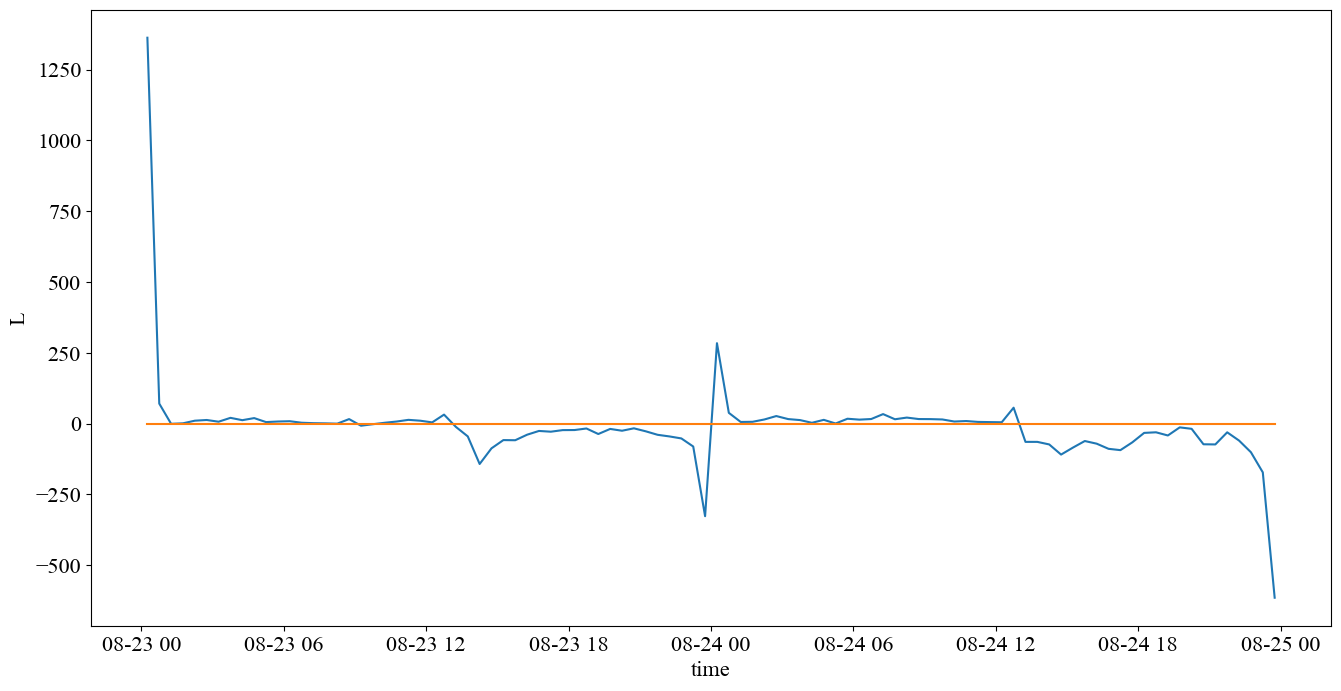

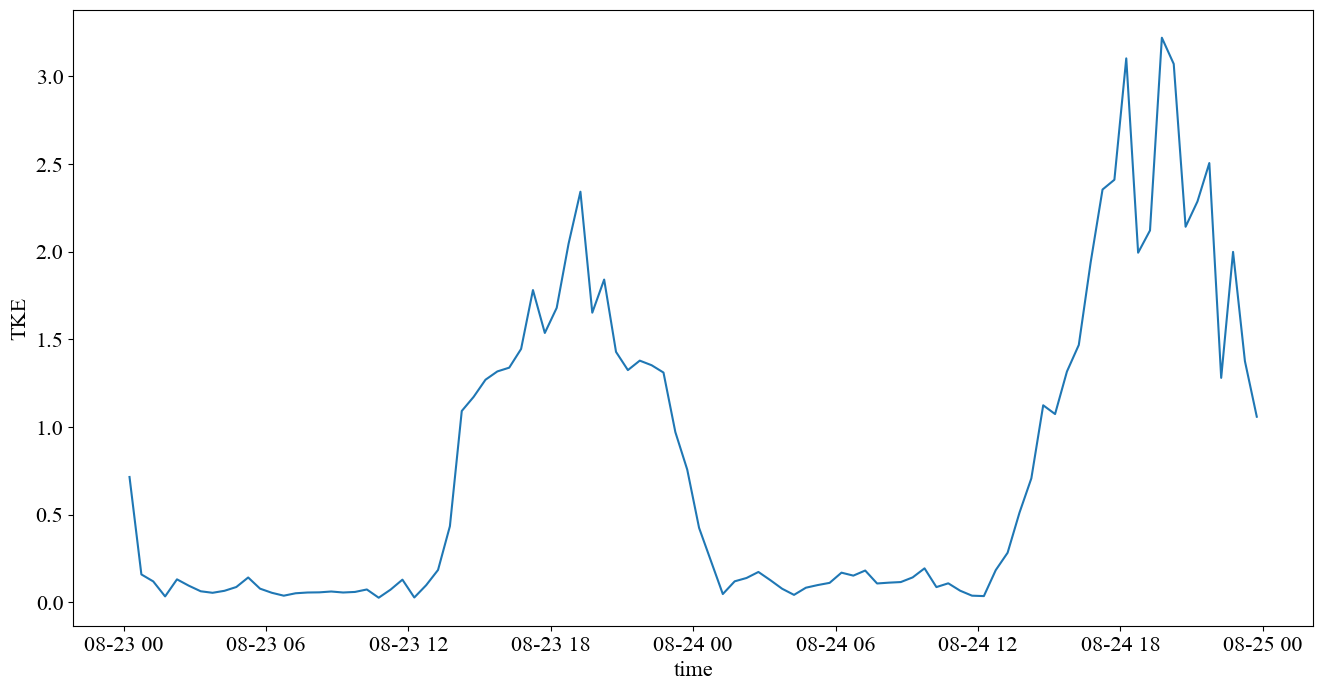

In [21]:
plt.figure(figsize=(16, 8))
plt.plot(A1_sonic['time'],A1_sonic['L'])
plt.plot(A1_sonic['time'],np.zeros(np.size(A1_sonic['time'])))
plt.xlabel('time')
plt.ylabel('L')
plt.figure(figsize=(16, 8))
plt.plot(A1_sonic['time'],A1_sonic['TKE'])
plt.xlabel('time')
plt.ylabel('TKE')

Text(0, 0.5, 'TKE')

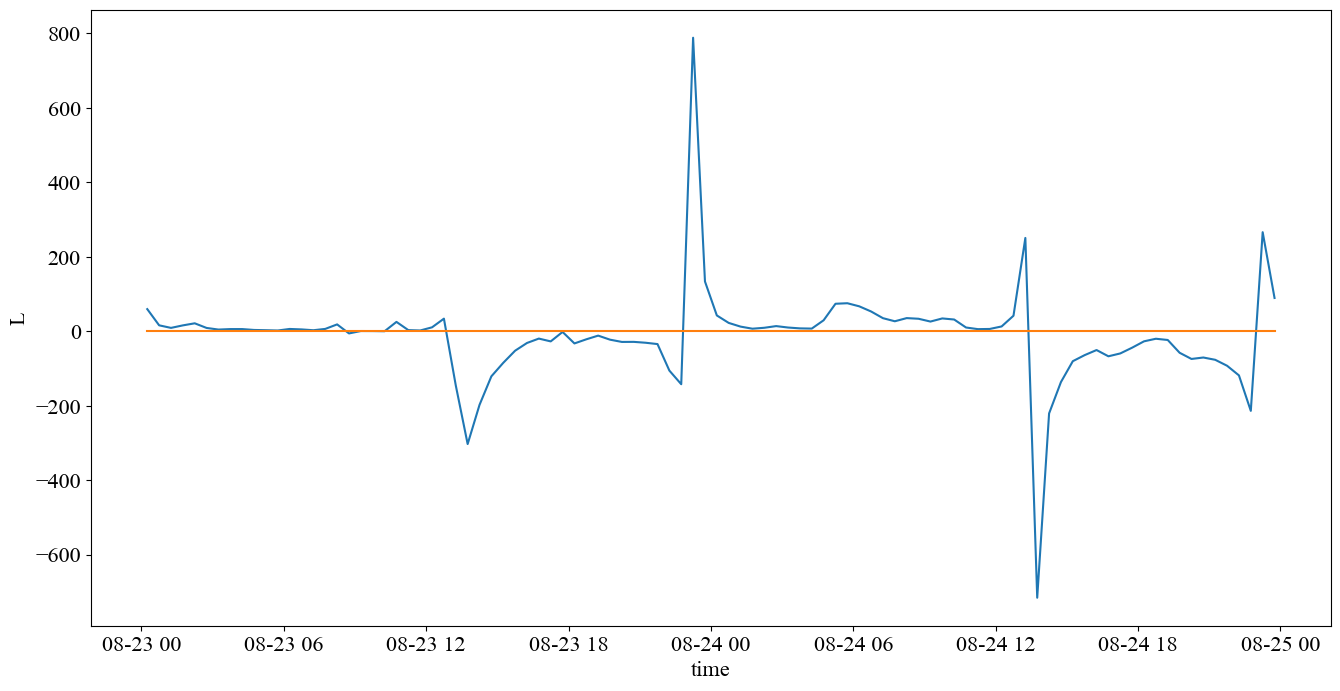

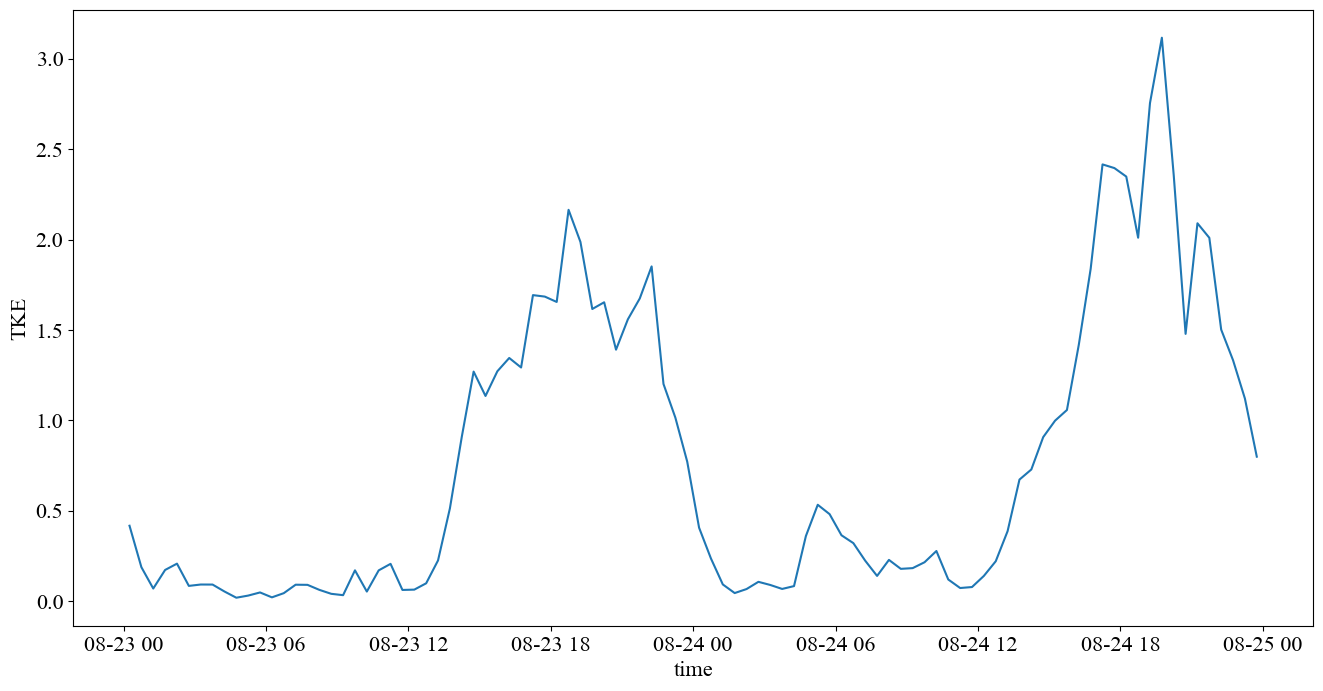

In [22]:
plt.figure(figsize=(16, 8))
plt.plot(A2_sonic['time'],A2_sonic['L'])
plt.plot(A2_sonic['time'],np.zeros(np.size(A2_sonic['time'])))
plt.xlabel('time')
plt.ylabel('L')
plt.figure(figsize=(16, 8))
plt.plot(A2_sonic['time'],A2_sonic['TKE'])
plt.xlabel('time')
plt.ylabel('TKE')

Text(0, 0.5, 'TKE')

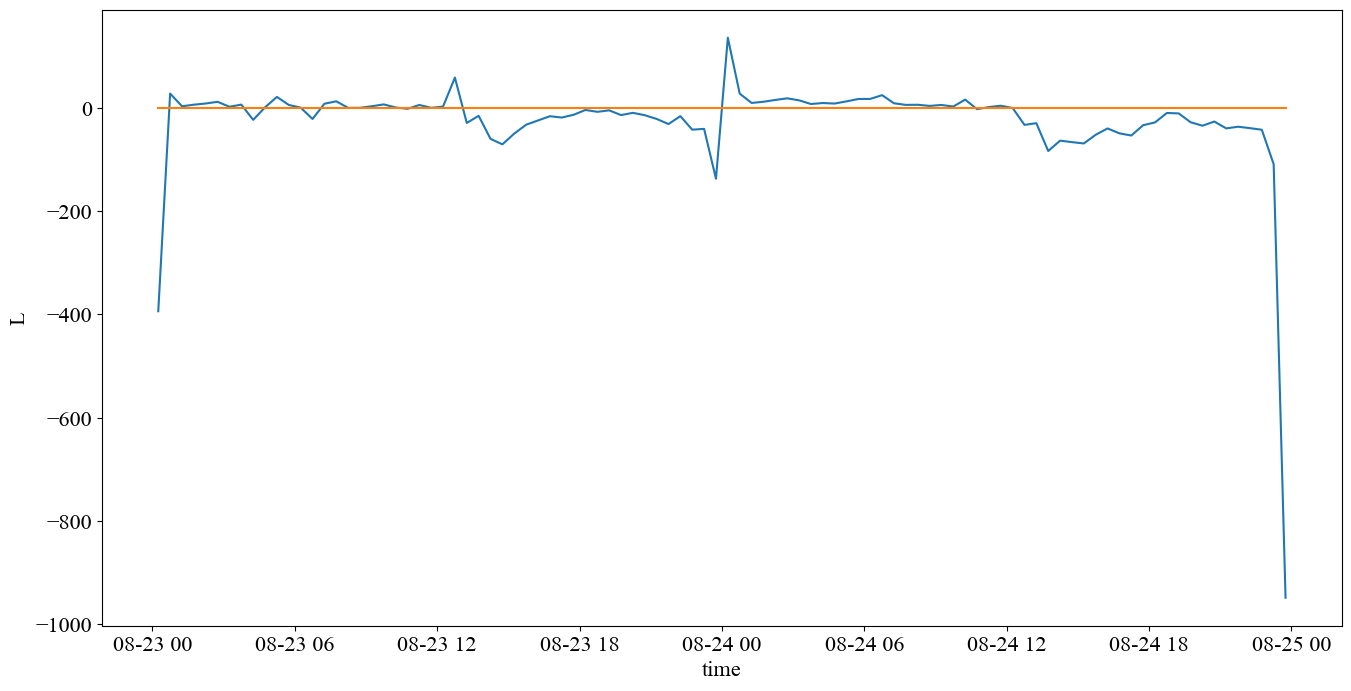

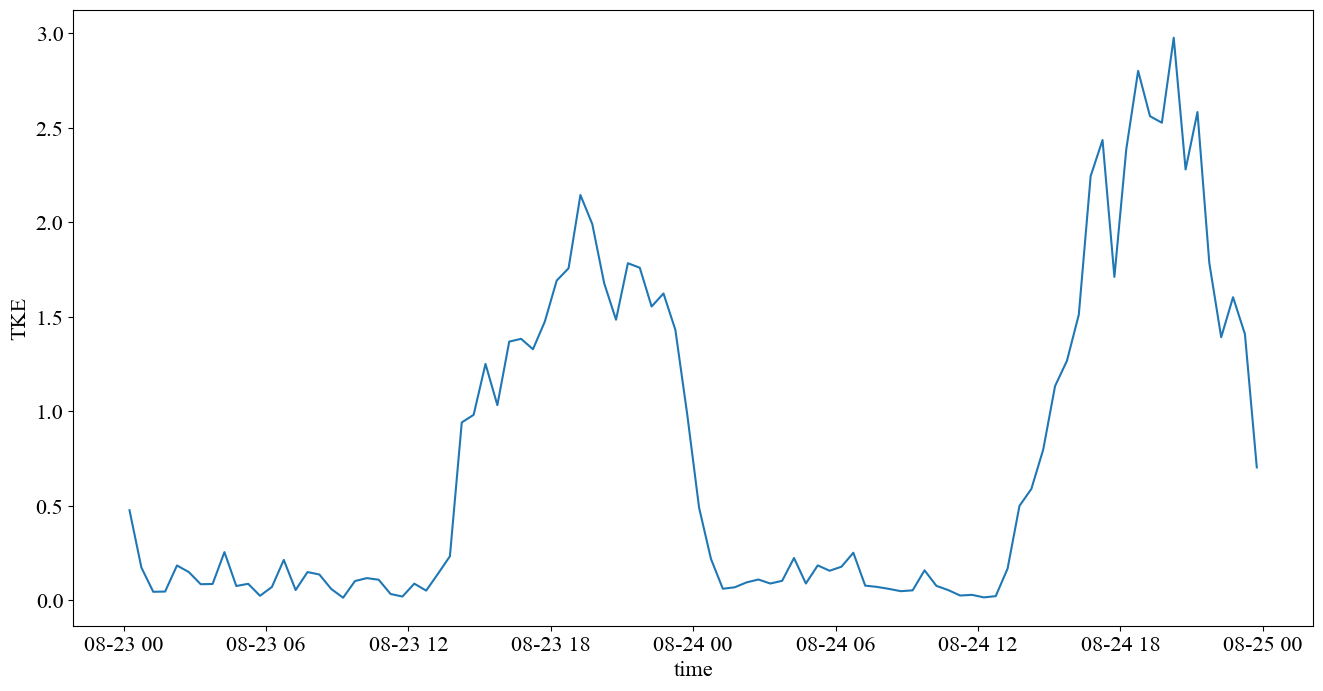

In [23]:
plt.figure(figsize=(16, 8))
plt.plot(A5_sonic['time'],A5_sonic['L'])
plt.plot(A5_sonic['time'],np.zeros(np.size(A5_sonic['time'])))
plt.ylabel('L')
plt.xlabel('time')
plt.figure(figsize=(16, 8))
plt.plot(A5_sonic['time'],A5_sonic['TKE'])
plt.xlabel('time')
plt.ylabel('TKE')

In [24]:
A1_sonic = A1_sonic.sel(time="2023-08-24")
A2_sonic = A2_sonic.sel(time="2023-08-24")
A5_sonic = A5_sonic.sel(time="2023-08-24")

# Download profiling LiDAR data

In [25]:
BProfile = xr.open_dataset(BASE_DIR/"KingPlainsData/Lidars/B_profiling_lidar_10min.nc")
A1Profile = xr.open_dataset(BASE_DIR/"KingPlainsData/Lidars/A1_profiling_lidar_10min.nc")

A2Profile = xr.open_dataset(BASE_DIR/"KingPlainsData/Lidars/A2_profiling_lidar_2min.nc")




# Print the variable names (just for verification)
variable_names = list(A1Profile.variables.keys())
print(variable_names)
variable_names = list(BProfile.variables.keys())
print(variable_names)

['U', 'WD', 'w', 'CNR', 'time', 'height']
['height', 'time', 'WS', 'WD', 'CNR', 'w']


In [26]:
A1Profile['height']


<xarray.DataArray 'height' (height: 11)> Size: 88B
array([ 40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240])
Coordinates:
  * height   (height) int64 88B 40 60 80 100 120 140 160 180 200 220 240

In [27]:
A2Profile['height']

<xarray.DataArray 'height' (height: 10)> Size: 80B
array([ 40.,  60.,  80., 100., 120., 140., 160., 180., 200., 220.])
Coordinates:
  * height   (height) float64 80B 40.0 60.0 80.0 100.0 ... 180.0 200.0 220.0
Attributes:
    units:      m
    long_name:  Meters above ground level

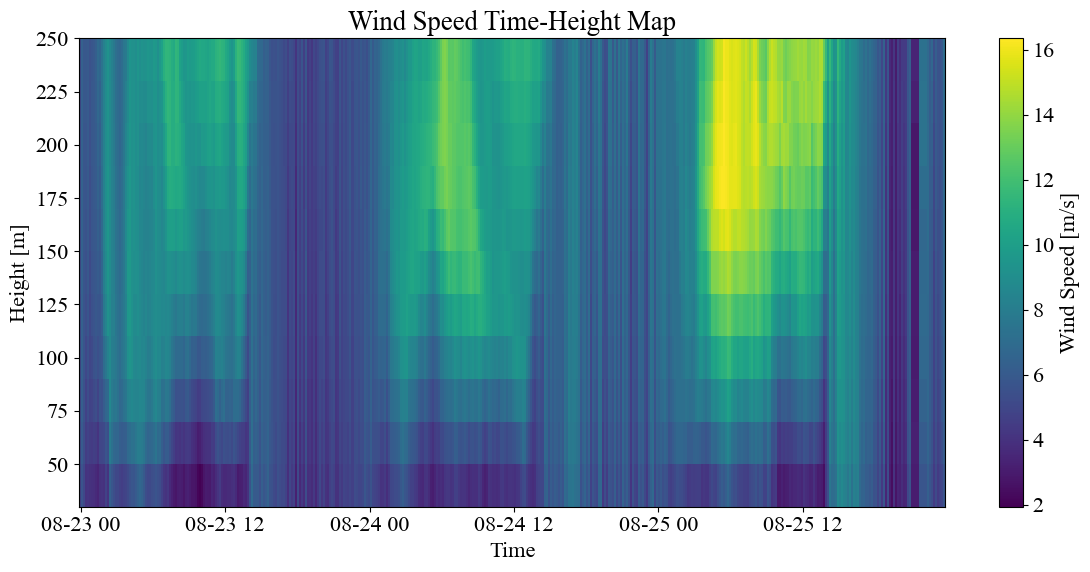

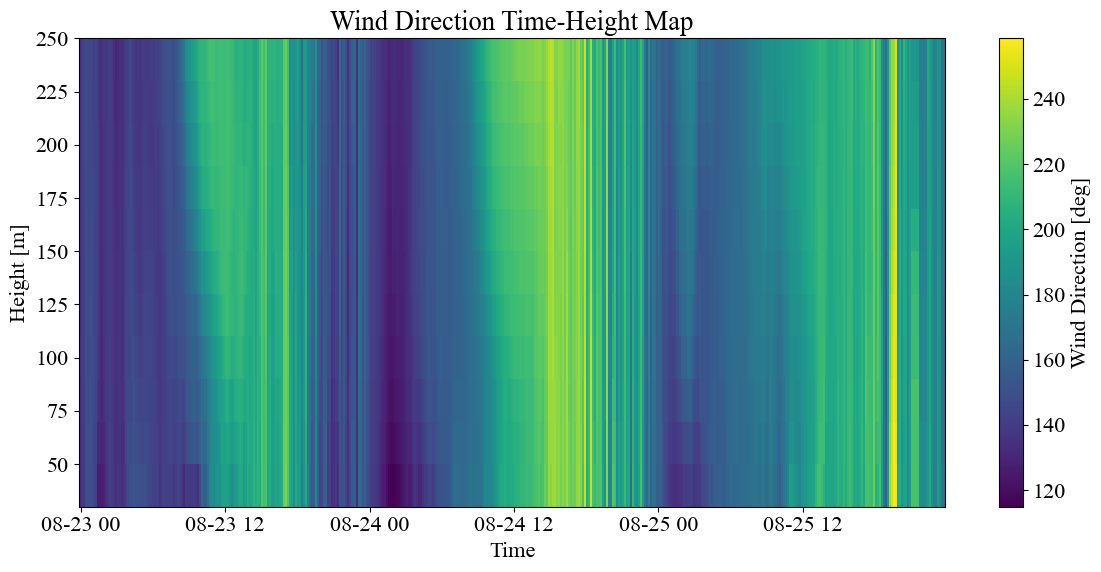

In [28]:


plt.figure(figsize=(12,6))
pc = plt.pcolormesh(A1Profile['time'],A1Profile['height'], A1Profile['U'].T, shading='auto', cmap='viridis')  # note the .T if dims are ('height','time')
plt.colorbar(pc, label='Wind Speed [m/s]')
plt.xlabel('Time')
plt.ylabel('Height [m]')
plt.title('Wind Speed Time-Height Map')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
pc = plt.pcolormesh(A1Profile['time'],A1Profile['height'], A1Profile['WD'].T, shading='auto', cmap='viridis')  # note the .T if dims are ('height','time')
plt.colorbar(pc, label='Wind Direction [deg]')
plt.xlabel('Time')
plt.ylabel('Height [m]')
plt.title('Wind Direction Time-Height Map')
plt.tight_layout()
plt.show()

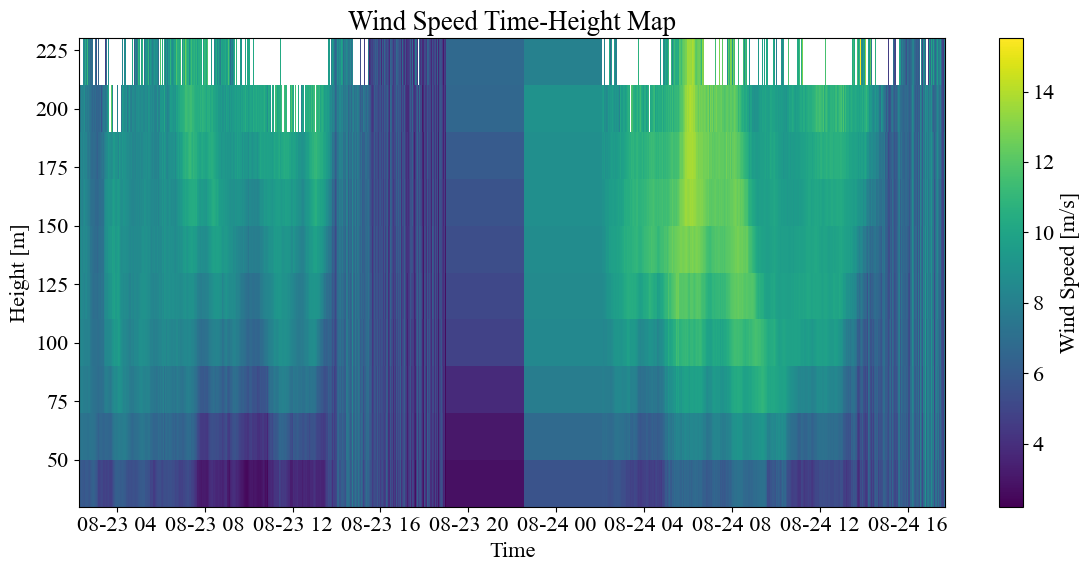

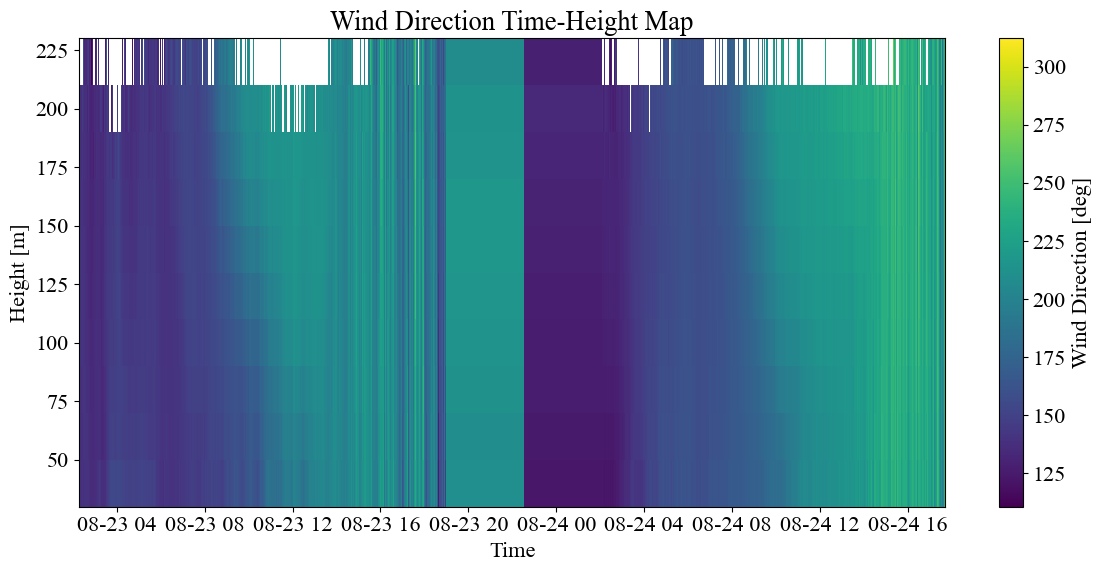

In [29]:


plt.figure(figsize=(12,6))
pc = plt.pcolormesh(A2Profile['time'],A2Profile['height'], A2Profile['U'].T, shading='auto', cmap='viridis')  # note the .T if dims are ('height','time')
plt.colorbar(pc, label='Wind Speed [m/s]')
plt.xlabel('Time')
plt.ylabel('Height [m]')
plt.title('Wind Speed Time-Height Map')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
pc = plt.pcolormesh(A2Profile['time'],A2Profile['height'], A2Profile['WD'].T, shading='auto', cmap='viridis')  # note the .T if dims are ('height','time')
plt.colorbar(pc, label='Wind Direction [deg]')
plt.xlabel('Time')
plt.ylabel('Height [m]')
plt.title('Wind Direction Time-Height Map')
plt.tight_layout()
plt.show()

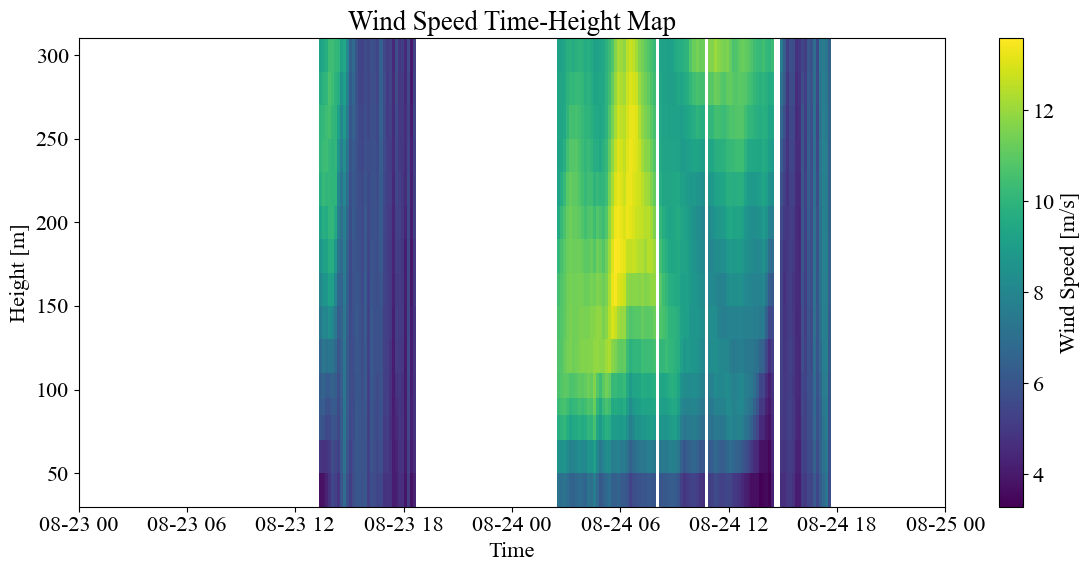

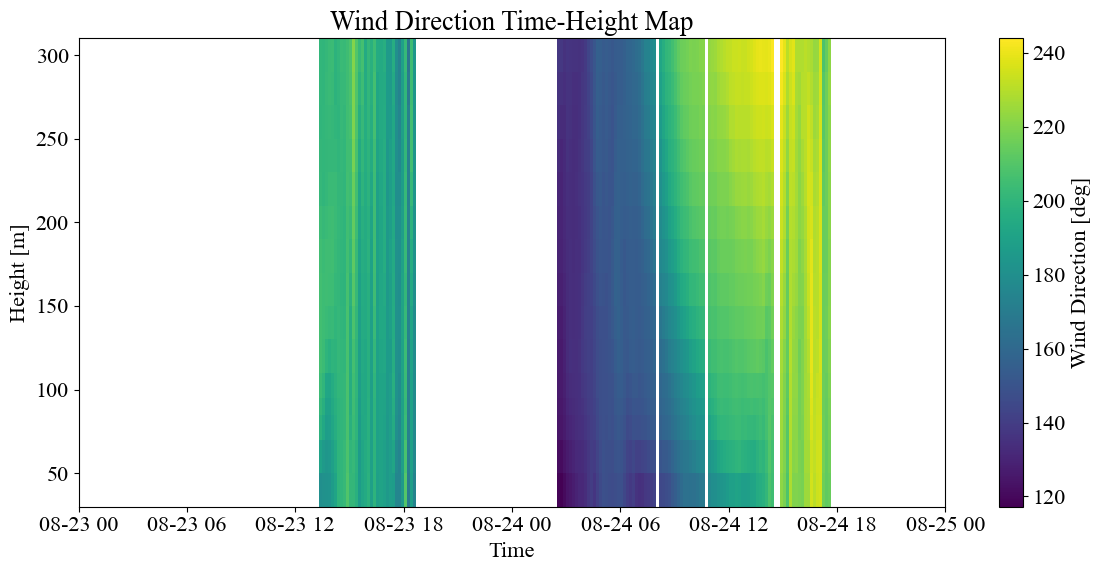

In [30]:


plt.figure(figsize=(12,6))
pc = plt.pcolormesh(BProfile['time'],BProfile['height'], BProfile['WS'].T, shading='auto', cmap='viridis')  # note the .T if dims are ('height','time')
plt.colorbar(pc, label='Wind Speed [m/s]')
plt.xlabel('Time')
plt.ylabel('Height [m]')
plt.title('Wind Speed Time-Height Map')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
pc = plt.pcolormesh(BProfile['time'],BProfile['height'], BProfile['WD'].T, shading='auto', cmap='viridis')  # note the .T if dims are ('height','time')
plt.colorbar(pc, label='Wind Direction [deg]')
plt.xlabel('Time')
plt.ylabel('Height [m]')
plt.title('Wind Direction Time-Height Map')
plt.tight_layout()
plt.show()

In [31]:
A1Profile = A1Profile.sel(time="2023-08-24")
A2Profile = A2Profile.sel(time="2023-08-24")
BProfile = BProfile.sel(time="2023-08-24")

# Download scanning LiDAR data

In [32]:
E36Scanning = xr.open_dataset(BASE_DIR/"KingPlainsData/Lidars/E36_scanning_lidar_10min.nc")
A1Scanning = xr.open_dataset(BASE_DIR/"KingPlainsData/Lidars/A1_scanning_lidar_10min.nc")

A2Scanning = xr.open_dataset(BASE_DIR/"KingPlainsData/Lidars/A2_scanning_lidar_10min.nc")



variable_names = list(A1Scanning.variables.keys())

# Print the variable names (just for verification)
print(variable_names)




['time', 'time_start', 'time_end', 'height', 'WS', 'WD', 'u', 'v', 'w', 'TI', 'TKE']


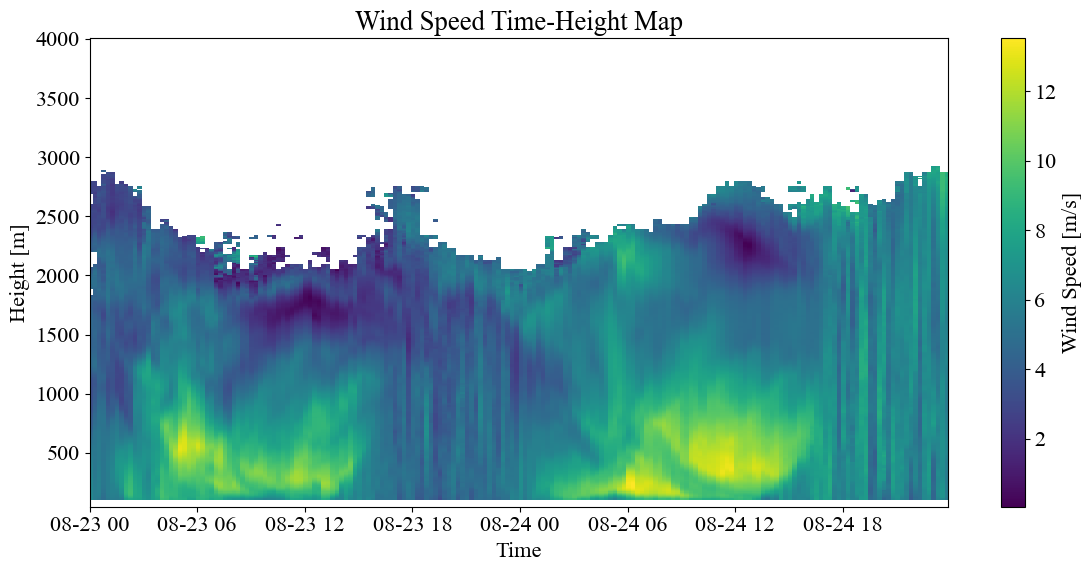

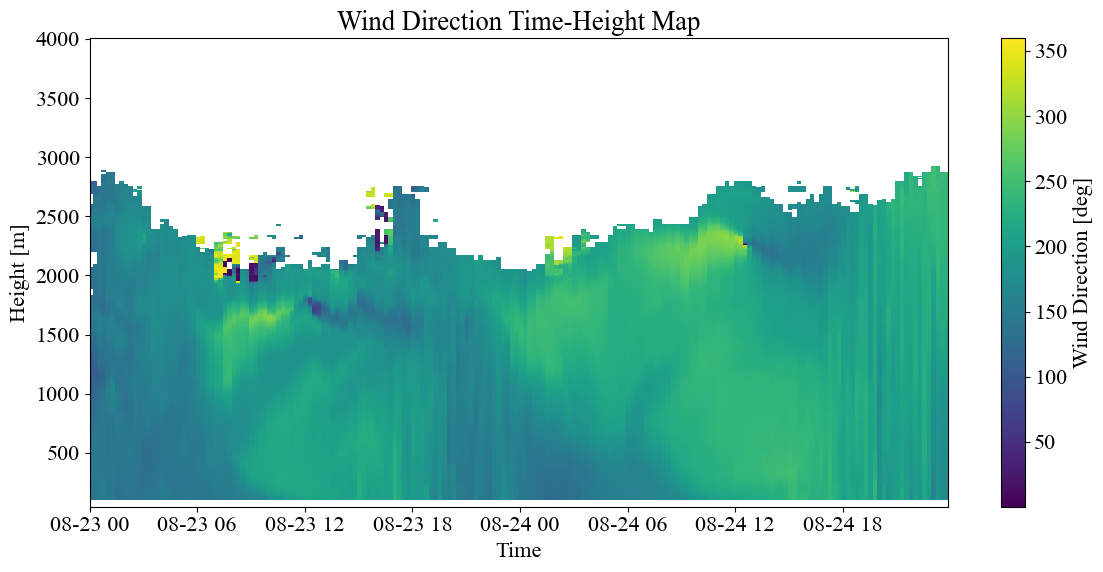

In [33]:


plt.figure(figsize=(12,6))
pc = plt.pcolormesh(A1Scanning['time'],A1Scanning['height'], A1Scanning['WS'].T, shading='auto', cmap='viridis')  # note the .T if dims are ('height','time')
plt.colorbar(pc, label='Wind Speed [m/s]')
plt.xlabel('Time')
plt.ylabel('Height [m]')
plt.title('Wind Speed Time-Height Map')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
pc = plt.pcolormesh(A1Scanning['time'],A1Scanning['height'], A1Scanning['WD'].T, shading='auto', cmap='viridis')  # note the .T if dims are ('height','time')
plt.colorbar(pc, label='Wind Direction [deg]')
plt.xlabel('Time')
plt.ylabel('Height [m]')
plt.title('Wind Direction Time-Height Map')
plt.tight_layout()
plt.show()

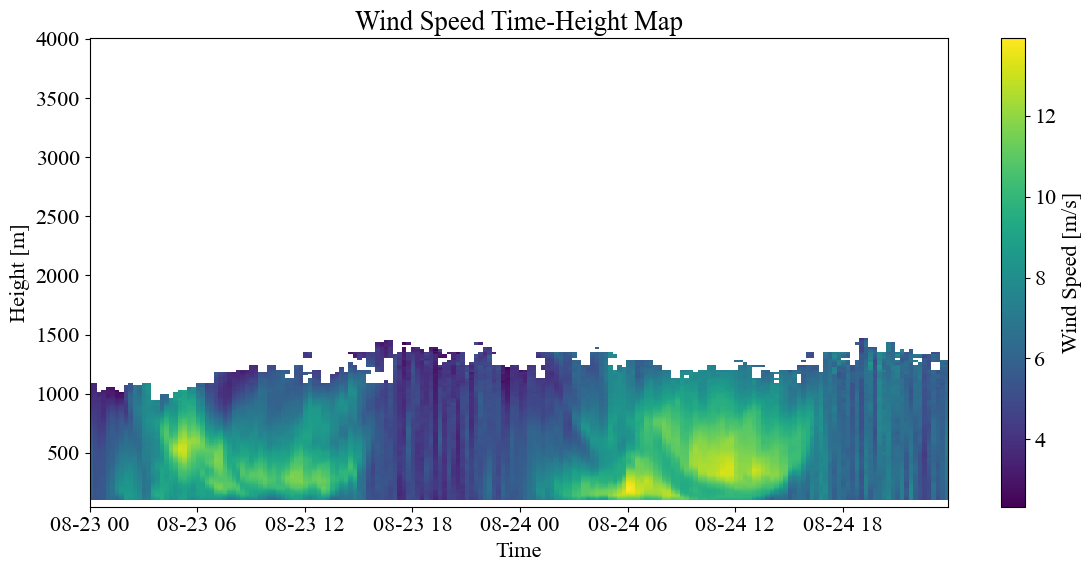

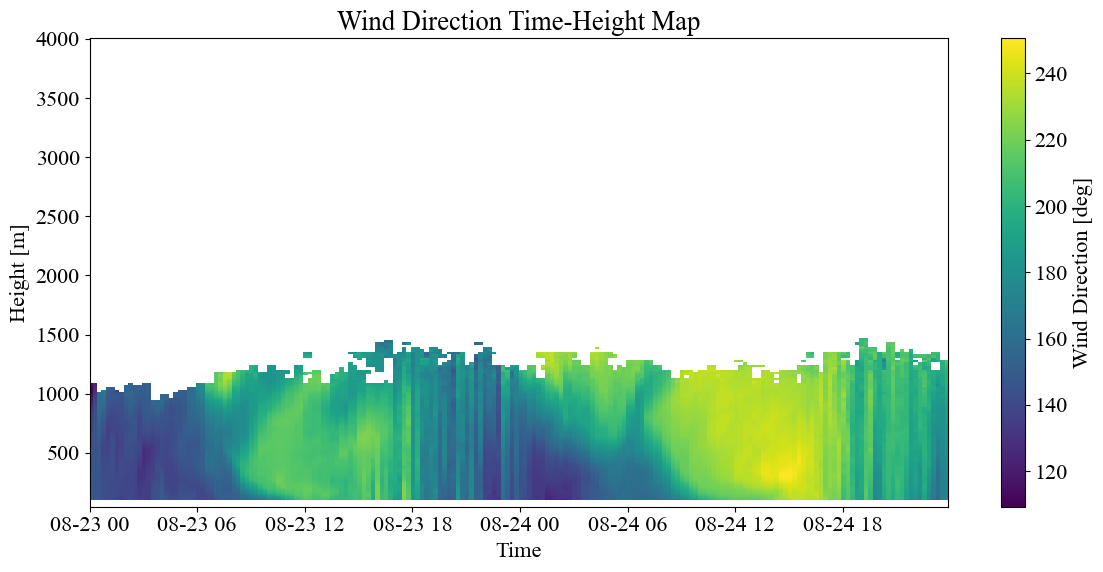

In [34]:


plt.figure(figsize=(12,6))
pc = plt.pcolormesh(A2Scanning['time'],A2Scanning['height'], A2Scanning['WS'].T, shading='auto', cmap='viridis')  # note the .T if dims are ('height','time')
plt.colorbar(pc, label='Wind Speed [m/s]')
plt.xlabel('Time')
plt.ylabel('Height [m]')
plt.title('Wind Speed Time-Height Map')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
pc = plt.pcolormesh(A2Scanning['time'],A2Scanning['height'], A2Scanning['WD'].T, shading='auto', cmap='viridis')  # note the .T if dims are ('height','time')
plt.colorbar(pc, label='Wind Direction [deg]')
plt.xlabel('Time')
plt.ylabel('Height [m]')
plt.title('Wind Direction Time-Height Map')
plt.tight_layout()
plt.show()

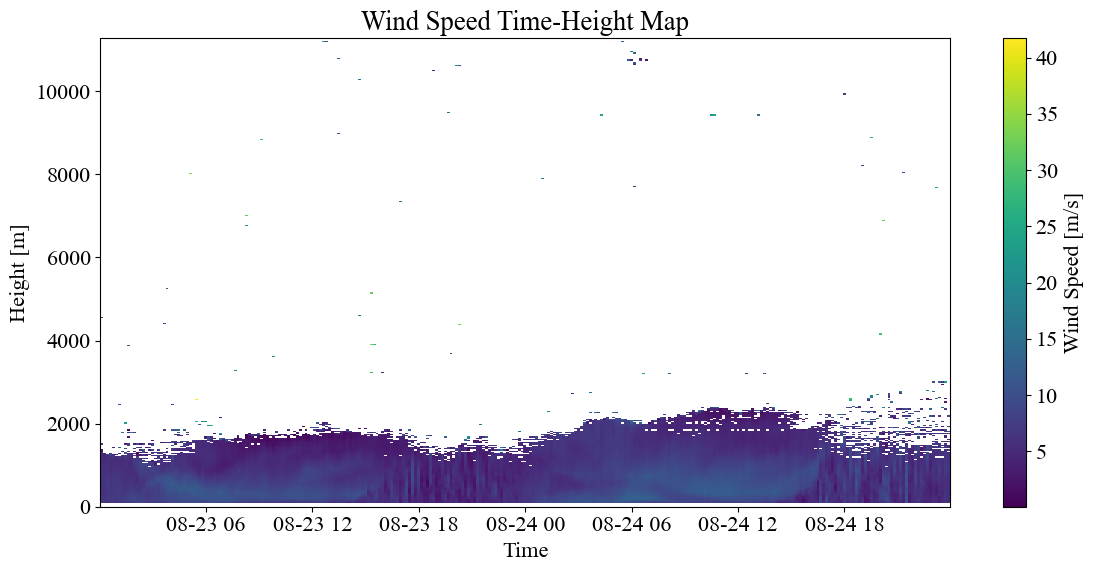

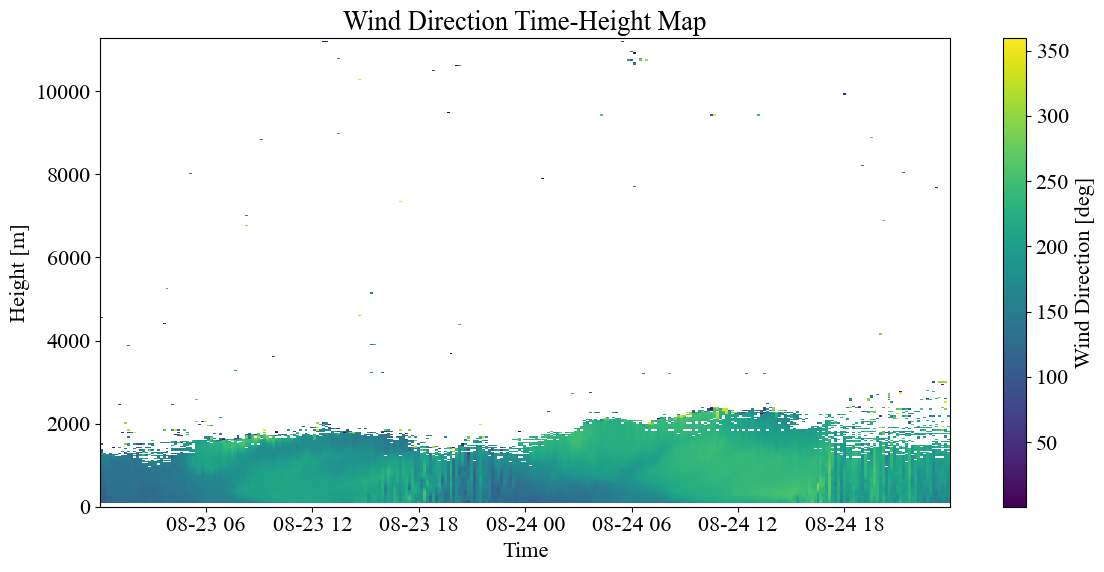

In [35]:


plt.figure(figsize=(12,6))
pc = plt.pcolormesh(E36Scanning['time'],E36Scanning['height'], E36Scanning['WS'].T, shading='auto', cmap='viridis')  # note the .T if dims are ('height','time')
plt.colorbar(pc, label='Wind Speed [m/s]')
plt.xlabel('Time')
plt.ylabel('Height [m]')
plt.title('Wind Speed Time-Height Map')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
pc = plt.pcolormesh(E36Scanning['time'],E36Scanning['height'], E36Scanning['WD'].T, shading='auto', cmap='viridis')  # note the .T if dims are ('height','time')
plt.colorbar(pc, label='Wind Direction [deg]')
plt.xlabel('Time')
plt.ylabel('Height [m]')
plt.title('Wind Direction Time-Height Map')
plt.tight_layout()
plt.show()

In [36]:
print(np.min(E36Scanning['height'].values))
print(E36Scanning['height'].values)

14.091802760958672
[   14.09180276    42.27541387    70.45902312    98.64262491
   126.82624161   155.00985086   183.19344521   211.37705445
   239.5606637    267.74427295   295.92788219   324.1114933
   352.29510069   380.47870994   408.66232105   436.84593029
   465.02953954   493.21312085   521.39675803   549.58033934
   577.76397653   605.94755784   634.13119502   662.31477633
   690.49841538   718.68199483   746.86563201   775.04921518
   803.23285237   831.41643368   859.60007086   887.78365403
   915.96729122   944.15087253   972.33445384  1000.51814876
  1028.70173007  1056.88531138  1085.06889269  1113.252474
  1141.43616706  1169.61974837  1197.80333154  1225.98691285
  1254.17060591  1282.35418722  1310.53777039  1338.7213517
  1366.90504476  1395.08862793  1423.27220924  1451.45579055
  1479.63948548  1507.82306679  1536.00664809  1564.1902294
  1592.37392433  1620.55750564  1648.74108694  1676.92467012
  1705.10836318  1733.29194635  1761.47552766  1789.65910897
  1817.842

# Check stability 

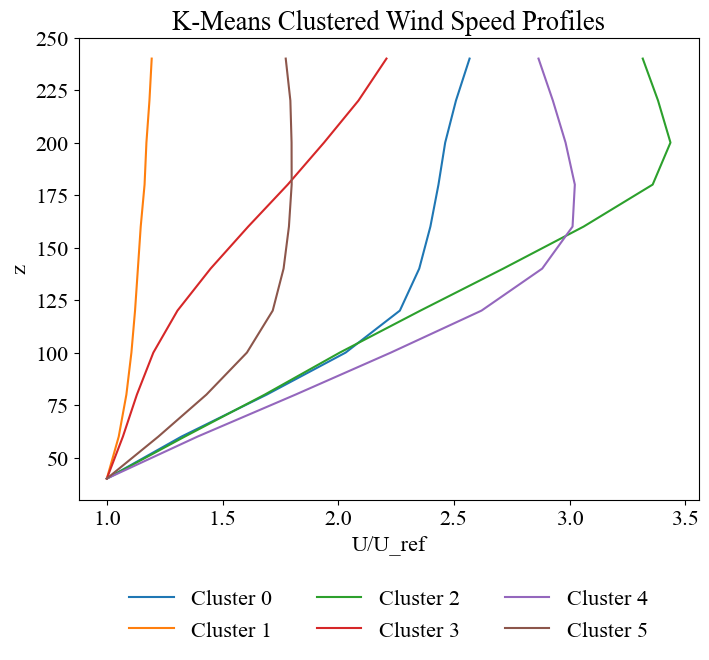

In [37]:
import numpy as np
from sklearn.cluster import KMeans
WD_rad = np.deg2rad(A1Profile['WD'])
WD_mean = np.rad2deg(np.arctan2(
    np.sin(WD_rad).mean(dim='height'),
    np.cos(WD_rad).mean(dim='height')
))
WD_mean = (WD_mean + 360) % 360  # normalize

mask = (WD_mean > 90) & (WD_mean < 270)
A1Profile = A1Profile.sel(time=mask, drop=True)


# Extract matrix where each row is a time snapshot
u_Ref = A1Profile['U'].sel(height = 40, method = 'nearest' ).values
profiles = A1Profile['U'].values /u_Ref[:,None] # shape: (time, height)
kmeans = KMeans(n_clusters=6, random_state=0).fit(profiles)
labels = kmeans.labels_   # shape: (time,)
# Cluster centers (average profile for each cluster)
centroids = kmeans.cluster_centers_

# Add cluster labels back to xarray for reference
A1Profile = A1Profile.assign(cluster=("time", labels))

# Plot cluster centroids
plt.figure(figsize=(8,6))
for i, centroid in enumerate(centroids):
    plt.plot( centroid, A1Profile.height.values,label=f"Cluster {i}")
plt.ylabel("z")
plt.xlabel("U/U_ref")
plt.title("K-Means Clustered Wind Speed Profiles")
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,  # number of columns in legend
    frameon=False)
plt.show()


In [38]:
import numpy as np

def shear_exponent_normalized(height, U_norm, z_ref, z_min=40, z_max=235):
    mask = (height >= z_min) & (height <= z_max)
    z = height[mask]
    u = U_norm[mask]

    valid = np.isfinite(u) & (u > 0)
    z = z[valid]
    u = u[valid]

    x = np.log(z / z_ref)
    y = np.log(u)

    alpha, _ = np.polyfit(x, y, 1)
    return alpha


/var/folders/b0/mmm07nss4jzc_ktswk1mkzm00000gn/T/ipykernel_46675/3546784789.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', 6)


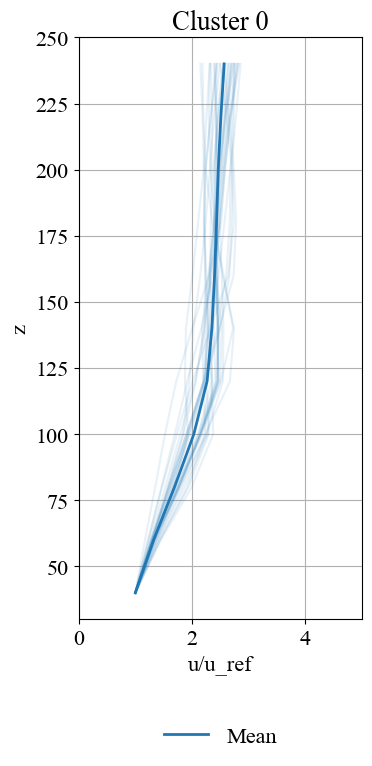

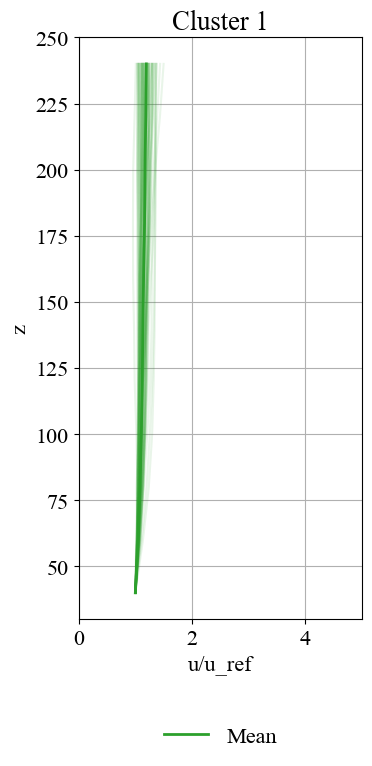

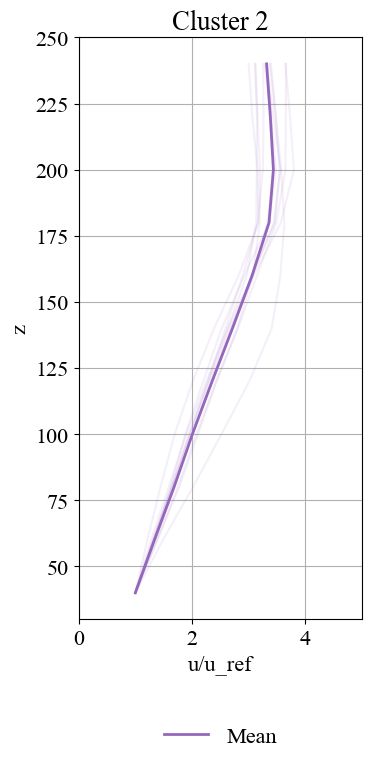

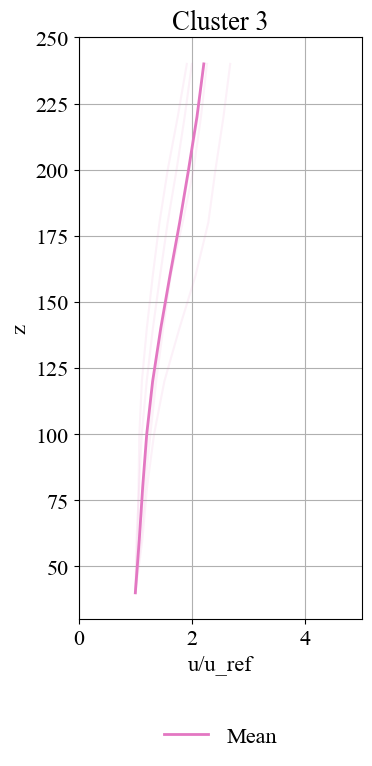

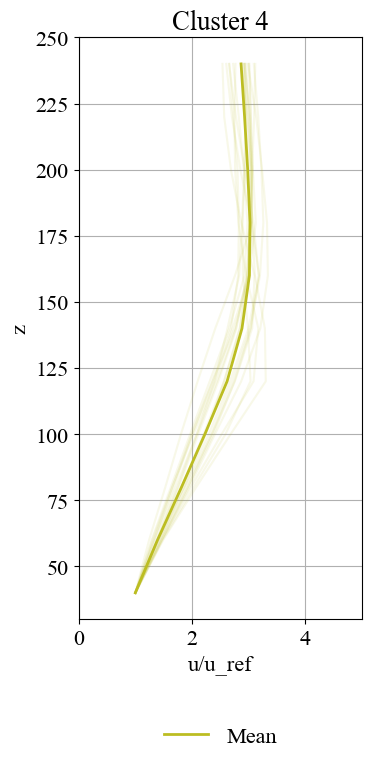

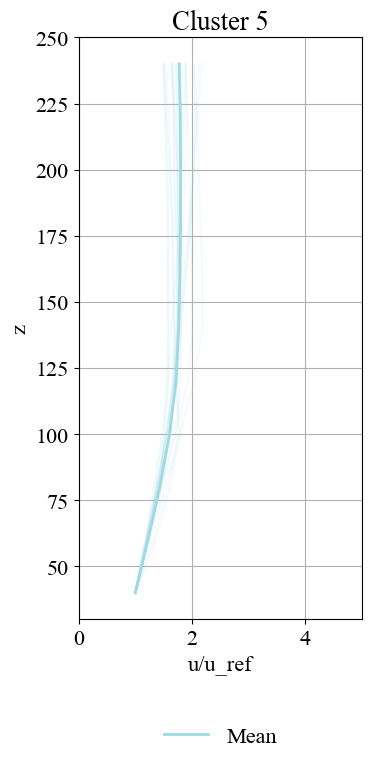

In [39]:

colors = plt.cm.get_cmap('tab20', 6)

height = A1Profile['height'].values 

shear_alpha = {}



for cluster_id in range(6):
    # Select profiles belonging to this cluster
    cluster_data = profiles[labels == cluster_id]  # shape: (n_profiles, n_distances)
    
    plt.figure(figsize=(4, 8))
    
    # Plot individual profiles
    for i in range(cluster_data.shape[0]):
        plt.plot( cluster_data[i], height,color=colors(cluster_id), alpha=0.1)
    

    # Plot mean profile
    mean_profile = cluster_data.mean(axis=0)

    shear_alpha[cluster_id] = shear_exponent_normalized(height, mean_profile, 40, z_min=40, z_max=235)
        
    plt.plot( mean_profile,height, color=colors(cluster_id), linewidth=2, label='Mean')

    plt.xlim(0,5)
    plt.title(f"Cluster {cluster_id}")
    plt.ylabel("z")
    plt.xlabel("u/u_ref")
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=3,  # number of columns in legend
        frameon=False)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [40]:
def stability_from_alpha(alpha):
    if alpha > 0.17:
        return "stable"
    elif alpha < 0.11:
        return "unstable"
    else:
        return "neutral"

cluster_stability = {
    c: stability_from_alpha(a) for c, a in shear_alpha.items()
}
stability_time = np.array([
    cluster_stability[c] for c in A1Profile['cluster'].values
])


In [41]:
print(cluster_stability)

{0: 'stable', 1: 'unstable', 2: 'stable', 3: 'stable', 4: 'stable', 5: 'stable'}


In [42]:
print(stability_time)

['unstable' 'unstable' 'unstable' 'unstable' 'stable' 'stable' 'stable'
 'stable' 'stable' 'stable' 'stable' 'stable' 'stable' 'stable' 'stable'
 'stable' 'stable' 'stable' 'stable' 'stable' 'stable' 'stable' 'stable'
 'stable' 'stable' 'stable' 'stable' 'stable' 'stable' 'stable' 'stable'
 'stable' 'stable' 'stable' 'stable' 'stable' 'stable' 'stable' 'stable'
 'stable' 'stable' 'stable' 'stable' 'stable' 'stable' 'stable' 'stable'
 'stable' 'stable' 'stable' 'stable' 'stable' 'stable' 'stable' 'stable'
 'stable' 'stable' 'stable' 'stable' 'stable' 'stable' 'stable' 'stable'
 'stable' 'stable' 'stable' 'stable' 'stable' 'stable' 'stable' 'stable'
 'stable' 'stable' 'stable' 'stable' 'stable' 'stable' 'stable' 'stable'
 'stable' 'stable' 'stable' 'stable' 'stable' 'stable' 'stable' 'stable'
 'unstable' 'unstable' 'unstable' 'unstable' 'unstable' 'unstable'
 'unstable' 'unstable' 'unstable' 'unstable' 'unstable' 'unstable'
 'unstable' 'unstable' 'unstable' 'unstable' 'unstable' 'unstabl

In [43]:
print(A1Profile['cluster'].values)

[1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 0 0 4 4 4 0 0 4 2 2 2 2 2 2 2
 2 2 4 2 4 0 0 4 4 4 4 4 2 4 4 4 4 0 0 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 5 5 0 0 0 0 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [44]:
print(A1Profile['time'].values)

['2023-08-24T00:05:00.000000000' '2023-08-24T00:15:00.000000000'
 '2023-08-24T00:25:00.000000000' '2023-08-24T00:35:00.000000000'
 '2023-08-24T00:45:00.000000000' '2023-08-24T00:55:00.000000000'
 '2023-08-24T01:05:00.000000000' '2023-08-24T01:15:00.000000000'
 '2023-08-24T01:25:00.000000000' '2023-08-24T01:35:00.000000000'
 '2023-08-24T01:45:00.000000000' '2023-08-24T01:55:00.000000000'
 '2023-08-24T02:05:00.000000000' '2023-08-24T02:15:00.000000000'
 '2023-08-24T02:25:00.000000000' '2023-08-24T02:35:00.000000000'
 '2023-08-24T02:45:00.000000000' '2023-08-24T02:55:00.000000000'
 '2023-08-24T03:05:00.000000000' '2023-08-24T03:15:00.000000000'
 '2023-08-24T03:25:00.000000000' '2023-08-24T03:35:00.000000000'
 '2023-08-24T03:45:00.000000000' '2023-08-24T03:55:00.000000000'
 '2023-08-24T04:05:00.000000000' '2023-08-24T04:15:00.000000000'
 '2023-08-24T04:25:00.000000000' '2023-08-24T04:35:00.000000000'
 '2023-08-24T04:45:00.000000000' '2023-08-24T04:55:00.000000000'
 '2023-08-24T05:05:00.000

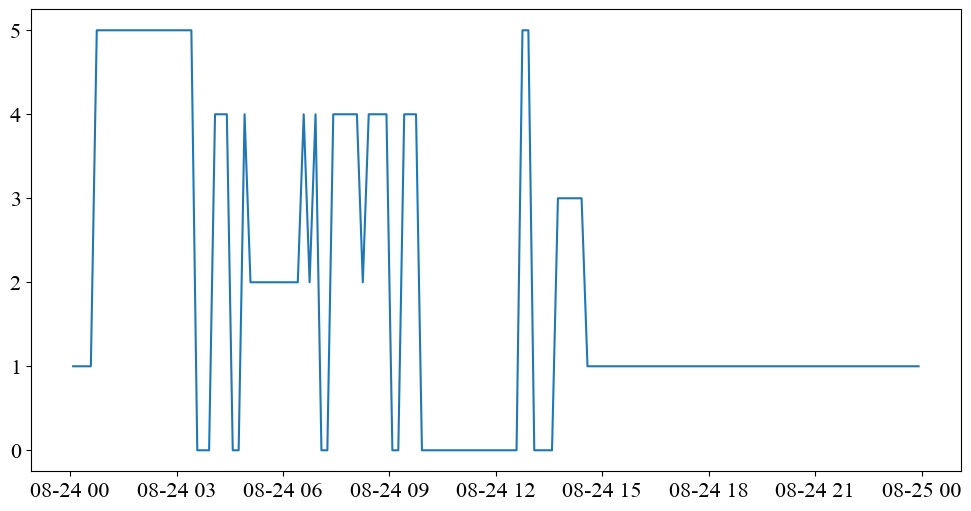

In [45]:
plt.figure(figsize=(12,6))

plt.plot(A1Profile['time'].values,A1Profile['cluster'].values)

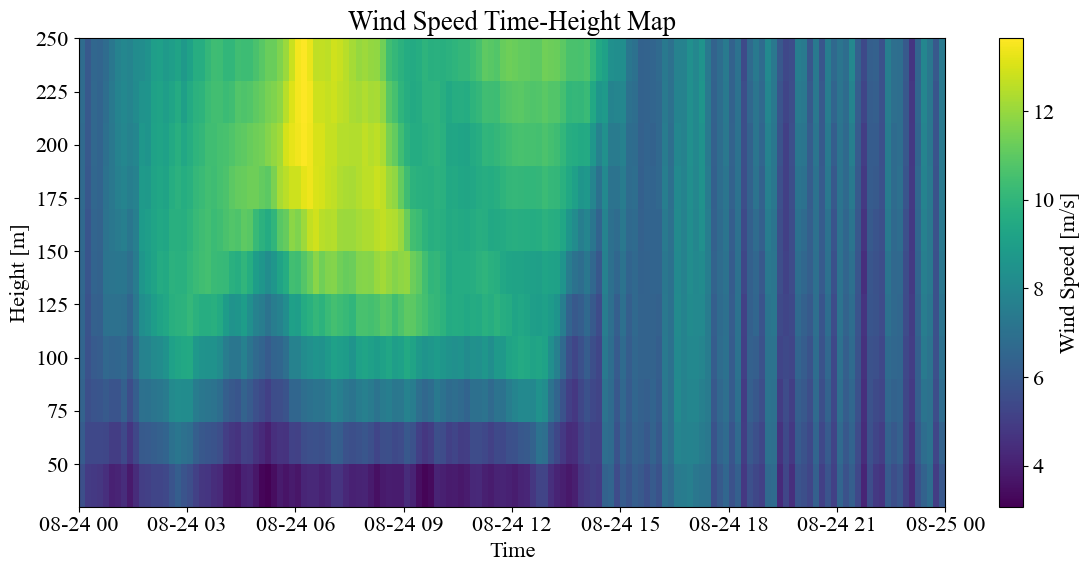

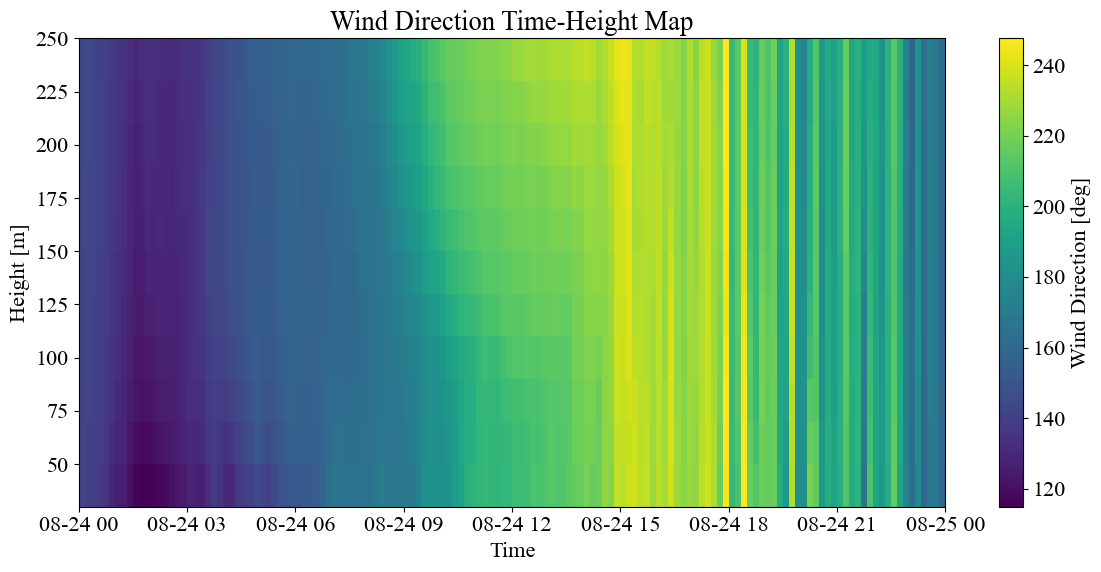

In [46]:

from matplotlib.colors import ListedColormap

stability_map = {"unstable": 0, "neutral": 1, "stable": 2}
stability_numeric = np.array([stability_map[s] for s in stability_time])

stability_cmap = ListedColormap(["red", "green", "blue"])

plt.figure(figsize=(12,6))
pc = plt.pcolormesh(A1Profile['time'],A1Profile['height'], A1Profile['U'].T, shading='auto', cmap='viridis')  # note the .T if dims are ('height','time')
plt.colorbar(pc, label='Wind Speed [m/s]')
plt.xlabel('Time')
plt.ylabel('Height [m]')
plt.title('Wind Speed Time-Height Map')
plt.tight_layout()
 
plt.show()

plt.figure(figsize=(12,6))
pc = plt.pcolormesh(A1Profile['time'],A1Profile['height'], A1Profile['WD'].T, shading='auto', cmap='viridis')  # note the .T if dims are ('height','time')
plt.colorbar(pc, label='Wind Direction [deg]')
plt.xlabel('Time')
plt.ylabel('Height [m]')
plt.title('Wind Direction Time-Height Map')
plt.tight_layout()
plt.show()

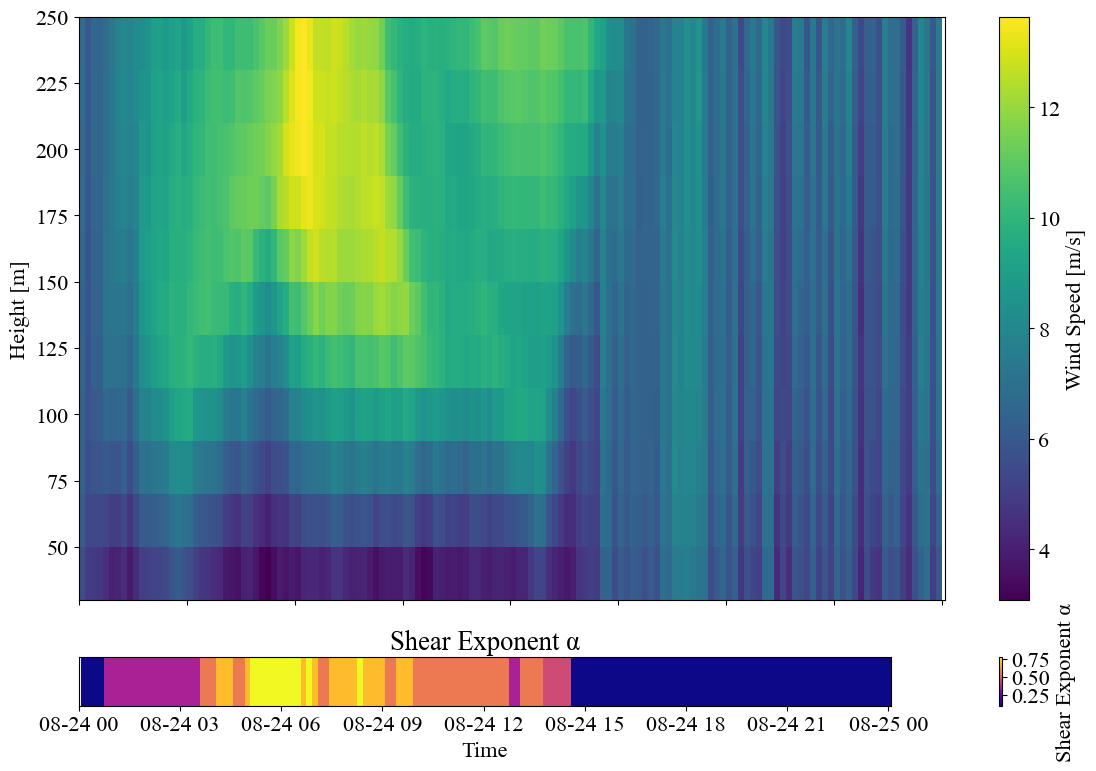

In [47]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

cluster_labels = A1Profile['cluster'].values
alpha_time = np.array([shear_alpha[c] for c in cluster_labels])

fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(12, 8),
    gridspec_kw={"height_ratios":[12,1]},
    sharex=True
)

# --- Wind speed ---
pc = ax1.pcolormesh(
    A1Profile['time'],
    A1Profile['height'],
    A1Profile['U'].T,
    shading='auto',
    cmap='viridis'
)
plt.colorbar(pc, ax=ax1, label="Wind Speed [m/s]")
ax1.set_ylabel("Height [m]")

# --- Shear exponent bar ---
# Create time edges for pcolormesh
time_vals = A1Profile['time'].values
time_edges = np.concatenate([time_vals, [time_vals[-1] + (time_vals[-1]-time_vals[-2])]])
alpha_2d = alpha_time.reshape(1, -1)

im = ax2.pcolormesh(
    time_edges,
    [0, 1],
    alpha_2d,
    cmap='plasma',
    norm=Normalize(vmin=min(alpha_time), vmax=max(alpha_time)),
    shading='auto'
)

ax2.set_yticks([])
ax2.set_xlabel("Time")
ax2.set_title("Shear Exponent α")

# Horizontal colorbar
plt.colorbar(im, ax=ax2, orientation='vertical', pad=0.1, label="Shear Exponent α")

plt.tight_layout()
plt.show()


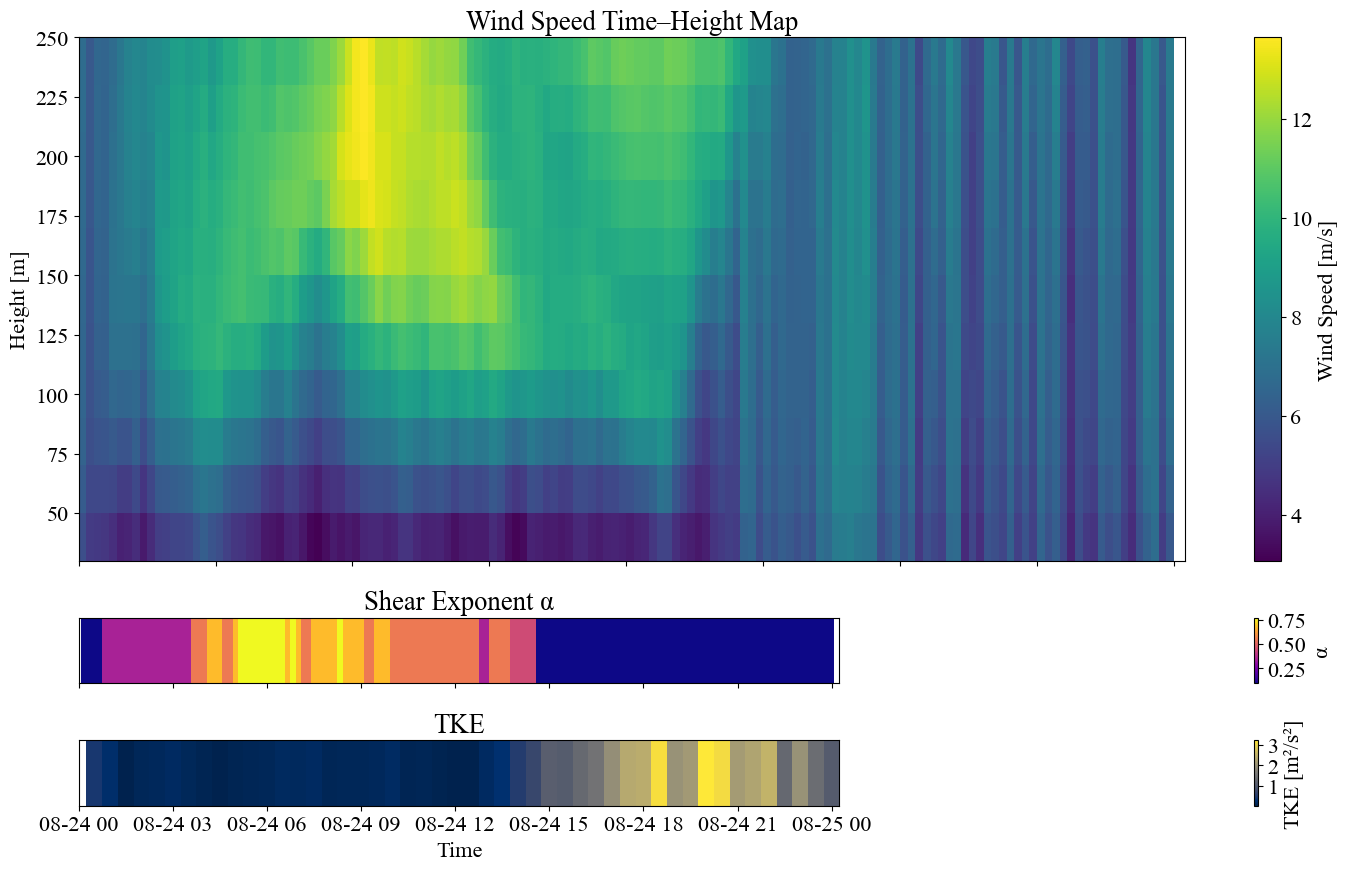

In [48]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

cluster_labels = A1Profile['cluster'].values
alpha_time = np.array([shear_alpha[c] for c in cluster_labels])
tke_time = A1_sonic['TKE'].values  # shape (time,)

fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1,
    figsize=(15, 9),
    gridspec_kw={"height_ratios":[8, 1, 1]},
    sharex=True
)

# ----------------------
# Wind speed colormap
# ----------------------
pc = ax1.pcolormesh(
    A1Profile['time'],
    A1Profile['height'],
    A1Profile['U'].T,
    shading='auto',
    cmap='viridis'
)
plt.colorbar(pc, ax=ax1, label="Wind Speed [m/s]")
ax1.set_ylabel("Height [m]")
ax1.set_title("Wind Speed Time–Height Map")

# ----------------------
# Shear exponent bar
# ----------------------
norm_alpha = Normalize(vmin=min(alpha_time), vmax=max(alpha_time))
time_vals = A1Profile['time'].values
time_edges = np.concatenate([time_vals, [time_vals[-1] + (time_vals[-1]-time_vals[-2])]])
alpha_2d = alpha_time.reshape(1, -1)

im_alpha = ax2.pcolormesh(
    time_edges,
    [0, 1],
    alpha_2d,
    cmap='plasma',
    norm=norm_alpha,
    shading='auto'
)
ax2.set_yticks([])
ax2.set_title("Shear Exponent α")
plt.colorbar(im_alpha, ax=ax2, orientation='vertical', pad=0.3, label="α")

# ----------------------
# TKE bar
# ----------------------
norm_tke = Normalize(vmin=np.nanmin(tke_time), vmax=np.nanmax(tke_time))
tke_2d = tke_time.reshape(1, -1)
time_vals = A1_sonic['time'].values
time_edges = np.concatenate([time_vals, [time_vals[-1] + (time_vals[-1]-time_vals[-2])]])

im_tke = ax3.pcolormesh(
    time_edges,
    [0,1],
    tke_2d,
    cmap='cividis',
    norm=norm_tke,
    shading='auto'
)
ax3.set_yticks([])
ax3.set_xlabel("Time")
ax3.set_title("TKE")
plt.colorbar(im_tke, ax=ax3, orientation='vertical', pad=0.3, label="TKE [m²/s²]")

plt.tight_layout()
plt.show()


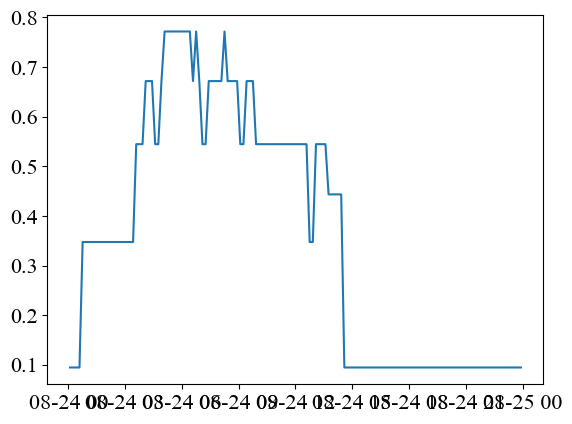

In [49]:
plt.plot(A1Profile['time'],alpha_time)

# Select time of interest : Unstable

In [50]:
time_of_interest = np.datetime64('2023-08-24T17:00:00')



In [51]:

power_at_time = SCADAdata['Power'].sel(time=time_of_interest)
direction_at_time = SCADAdata['Wind Direction'].sel(__resample_dim__=time_of_interest)
speed_at_time = SCADAdata['Wind Speed'].sel(time=time_of_interest)

In [52]:

A1_profile_data = A1Profile.sel(time=time_of_interest,method='nearest')
A2_profile_data = A2Profile.sel(time=time_of_interest,method='nearest')
B_profile_data = BProfile.sel(time=time_of_interest,method='nearest')

print(BProfile['time'].max())

<xarray.DataArray 'time' ()> Size: 8B
array('2023-08-24T23:55:00.000000000', dtype='datetime64[ns]')


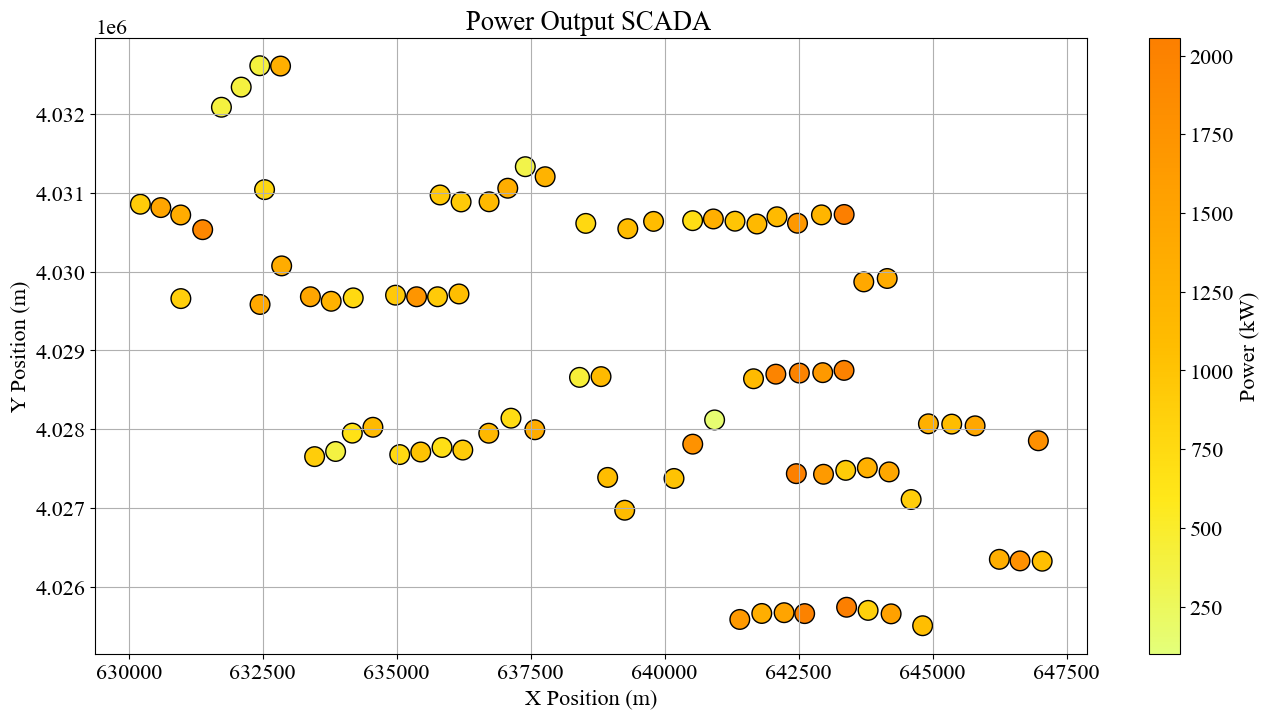

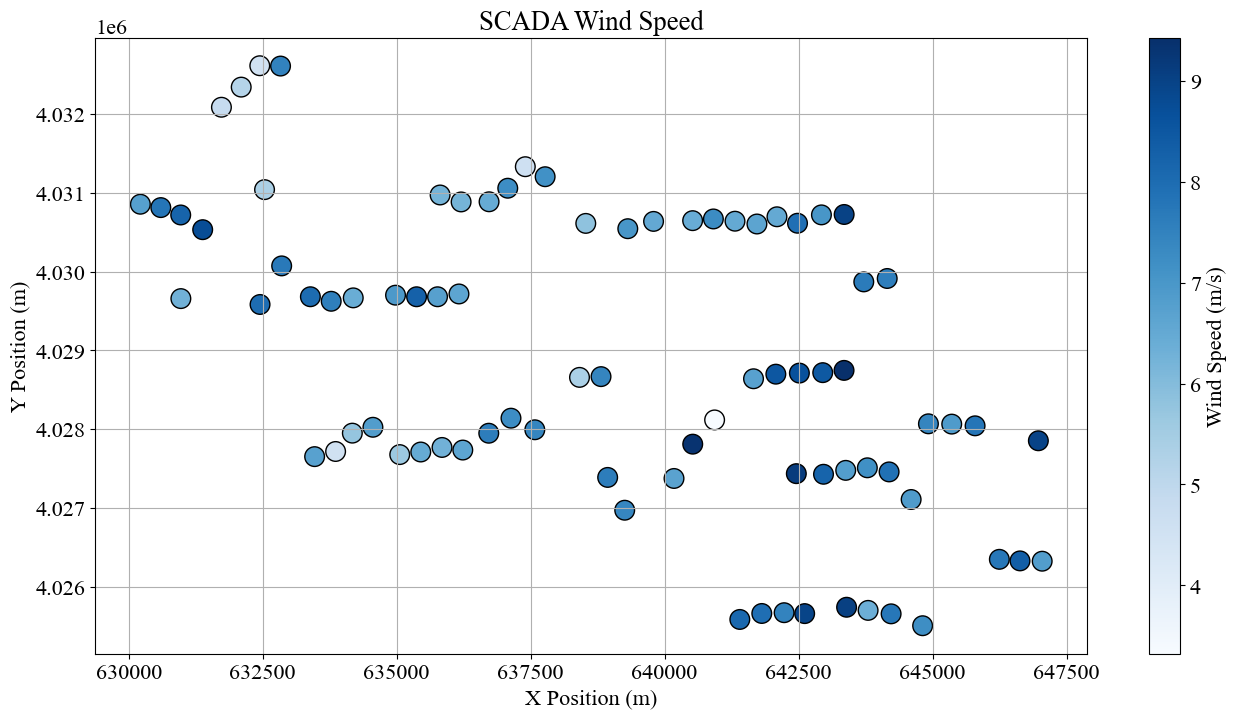

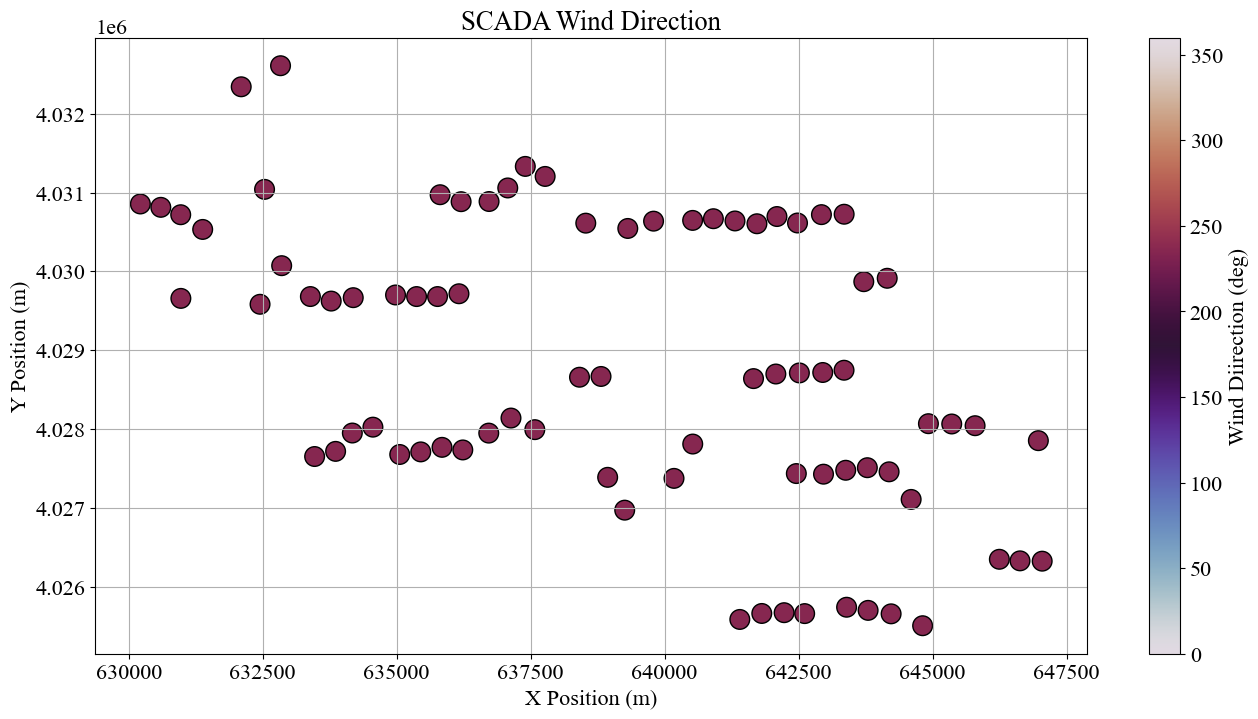

Wind Speed 7.128258365725813, Wind Direction: 235.2848825898832


In [53]:
file_path = BASE_DIR/'KingPlainsData/turbines_with_specs.csv'
turbine_df = pd.read_csv(file_path)

turbine_names = turbine_df['# name'][0:88]


# Example turbine locations (separate latitude and longitude columns)
layout_x = turbine_df[' x'][0:88]  # Latitude values

 
layout_y = turbine_df[' y'][0:88]  # Longitude values

plt.figure(figsize=(16, 8))
SCADAscatter = plt.scatter(layout_x,layout_y, c=power_at_time, cmap='Wistia', s=200, edgecolors='k', vmin=100, vmax=np.max(power_at_time))

# Add a colorbar
plt.colorbar(SCADAscatter, label='Power (kW)')
# Add titles and labels
plt.title(f'Power Output SCADA ')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 8))
wind = plt.scatter(layout_x,layout_y, c=speed_at_time, cmap='Blues', s=200, edgecolors='k', vmin=np.min(speed_at_time), vmax=np.max(speed_at_time))

# Add a colorbar
plt.colorbar(wind, label='Wind Speed (m/s)')
# Add titles and labels
plt.title(f'SCADA Wind Speed')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 8))
direction = plt.scatter(layout_x,layout_y, c=direction_at_time, cmap='twilight', s=200, edgecolors='k', vmin=0, vmax=360)

# Add a colorbar
plt.colorbar(direction, label='Wind Diirection (deg)')
# Add titles and labels
plt.title(f'SCADA Wind Direction')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.grid(True)
plt.show()

print(f"Wind Speed {np.mean(speed_at_time).values}, Wind Direction: {np.mean(direction_at_time).values}")



In [54]:
A1_sonic_data = A1_sonic.sel(time=time_of_interest,method='nearest')
A2_sonic_data = A2_sonic.sel(time=time_of_interest,method='nearest')
A5_sonic_data = A5_sonic.sel(time=time_of_interest,method='nearest')


# List of your selected datasets
datasets = [A1_sonic_data, A2_sonic_data, A5_sonic_data]
names = ['A1_sonic', 'A2_sonic', 'A5_sonic']

# Prepare a table
rows = []
for name, ds in zip(names, datasets):
    # ds is a scalar Dataset (single time), convert to dict
    row = {var: ds[var].values.item() for var in ds.data_vars}  # extract scalar values
    row['sonic'] = name
    row['time'] = pd.Timestamp(ds['time'].values)
    rows.append(row)

# Convert to DataFrame
table = pd.DataFrame(rows)

# Optional: reorder columns
cols = ['sonic', 'time'] + [c for c in table.columns if c not in ['sonic','time']]
table = table[cols]

print(table)



      sonic                time     WS     WD      u      v        w    T_s  \
0  A1_sonic 2023-08-24 17:15:00  4.749  235.5  2.546 -3.699 -0.12060  313.1   
1  A2_sonic 2023-08-24 17:15:00  5.082  226.5  3.309 -3.480  0.04568  312.6   
2  A5_sonic 2023-08-24 17:15:00  5.243  231.6  3.109 -3.922 -0.16950  313.2   

     F_s       u_*      TKE        L  
0  151.7  0.541110  2.35340 -94.0175  
1  174.1  0.486724  2.41540 -59.5916  
2  198.1  0.490510  2.43615 -53.6365  


Let's check velocity profiles for inflow in Armadilo Flats and King Plains

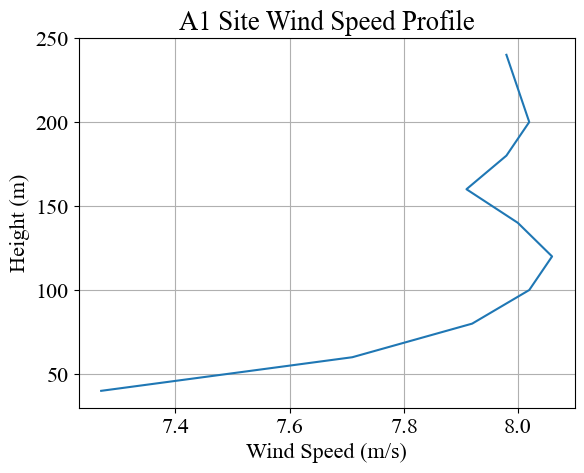

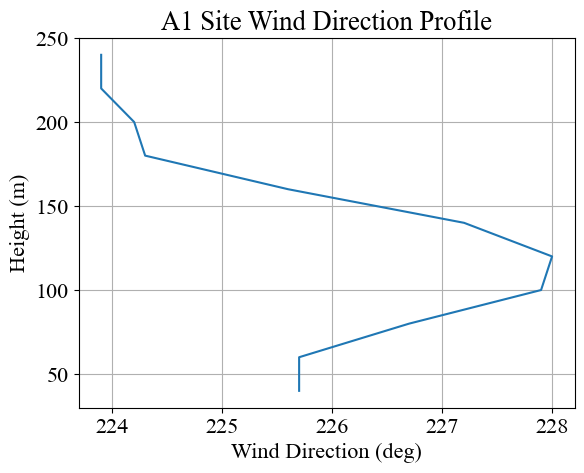

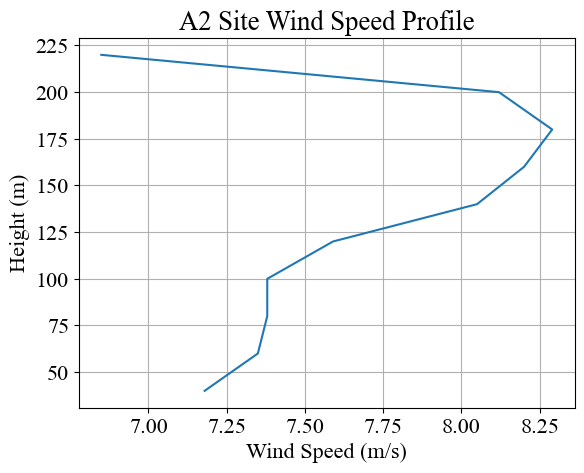

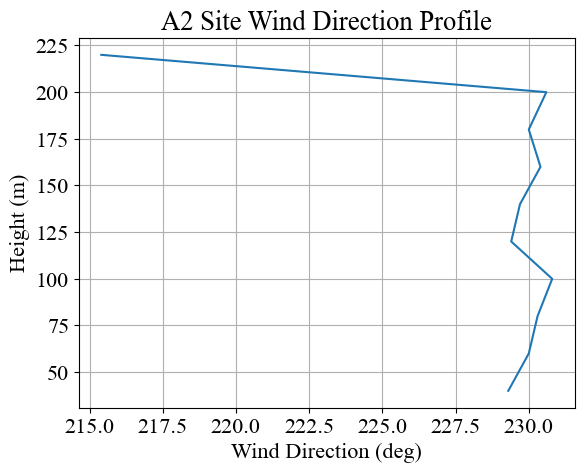

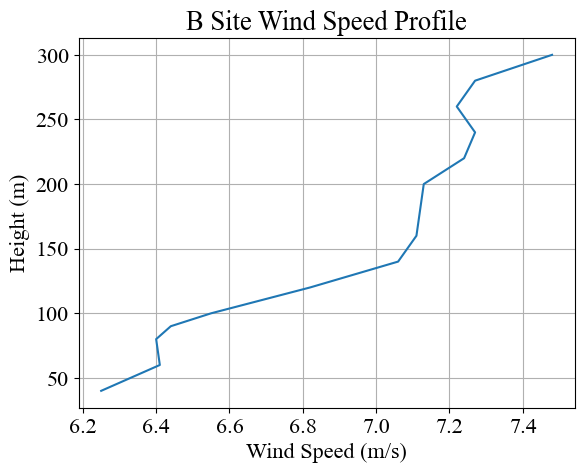

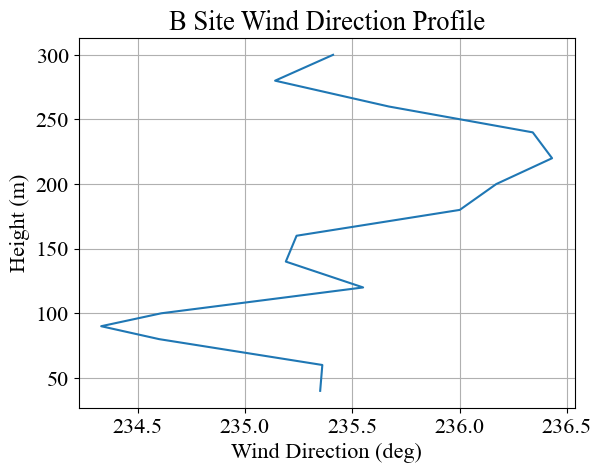

In [55]:
plt.plot(A1_profile_data['U'],A1_profile_data['height'])
plt.title('A1 Site Wind Speed Profile')
plt.ylabel('Height (m)')
plt.xlabel('Wind Speed (m/s)')
plt.grid(True)
plt.show()

plt.plot(A1_profile_data['WD'],A1_profile_data['height'])
plt.title('A1 Site Wind Direction Profile')
plt.ylabel('Height (m)')
plt.xlabel('Wind Direction (deg)')
plt.grid(True)
plt.show()

plt.plot(A2_profile_data['U'],A2_profile_data['height'])
plt.title('A2 Site Wind Speed Profile')
plt.ylabel('Height (m)')
plt.xlabel('Wind Speed (m/s)')
plt.grid(True)
plt.show()
plt.plot(A2_profile_data['WD'],A2_profile_data['height'])
plt.title('A2 Site Wind Direction Profile')
plt.ylabel('Height (m)')
plt.xlabel('Wind Direction (deg)')
plt.grid(True)
plt.show()

plt.plot(B_profile_data['WS'],B_profile_data['height'])
plt.title('B Site Wind Speed Profile')
plt.ylabel('Height (m)')
plt.xlabel('Wind Speed (m/s)')
plt.grid(True)
plt.show()
plt.plot(B_profile_data['WD'],B_profile_data['height'])
plt.title('B Site Wind Direction Profile')
plt.ylabel('Height (m)')
plt.xlabel('Wind Direction (deg)')
plt.grid(True)
plt.show()

In [56]:
A1_scanning_data = A1Scanning.sel(time=time_of_interest,method='nearest')
A2_scanning_data = A2Scanning.sel(time=time_of_interest,method='nearest')
E36_scanning_data = E36Scanning.sel(time=time_of_interest,method='nearest')


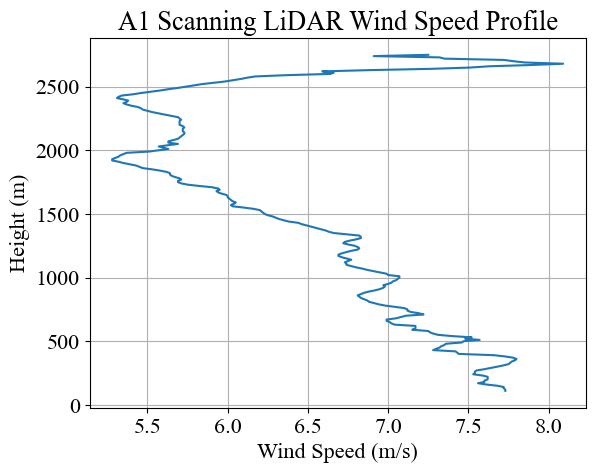

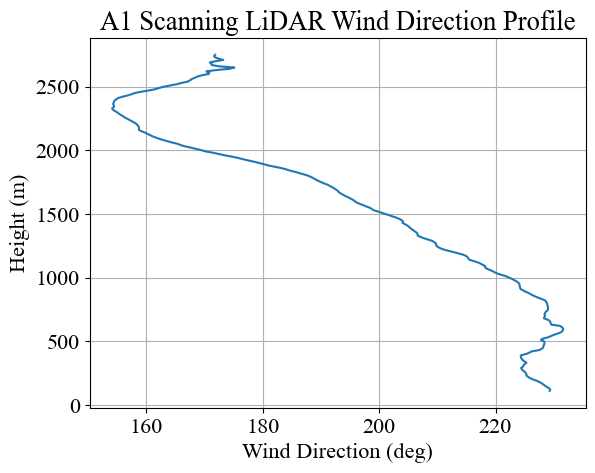

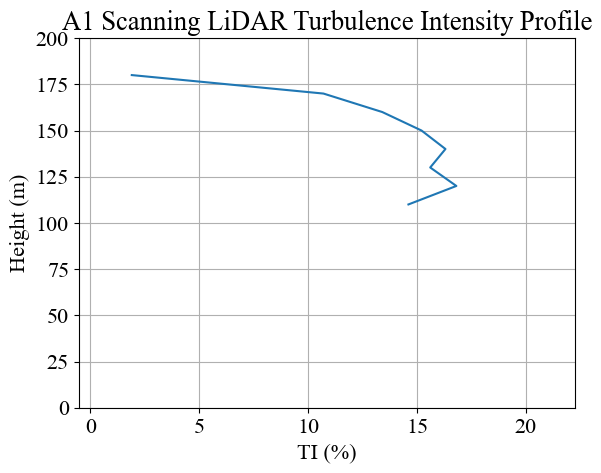

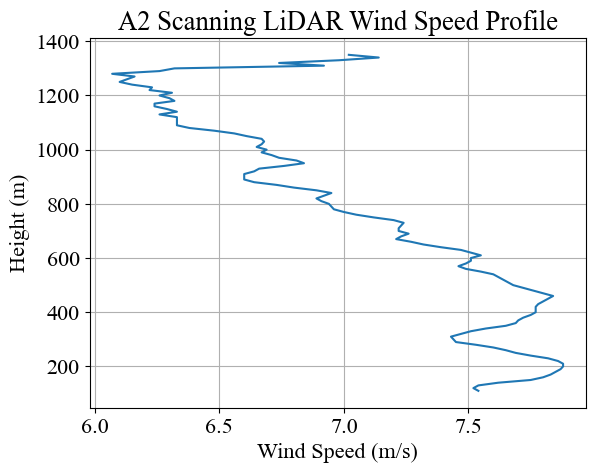

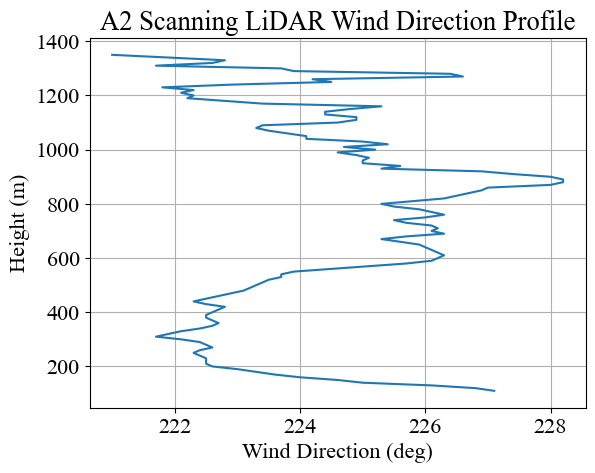

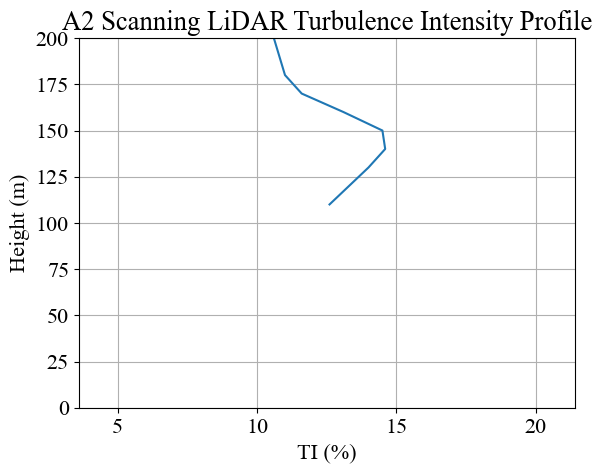

In [57]:
plt.plot(A1_scanning_data['WS'],A1_scanning_data['height'])
plt.title('A1 Scanning LiDAR Wind Speed Profile')
plt.ylabel('Height (m)')
plt.xlabel('Wind Speed (m/s)')
plt.grid(True)
plt.show()

plt.plot(A1_scanning_data['WD'],A1_scanning_data['height'])
plt.title('A1 Scanning LiDAR Wind Direction Profile')
plt.ylabel('Height (m)')
plt.xlabel('Wind Direction (deg)')
plt.grid(True)
plt.show()

plt.plot(A1_scanning_data['TI'],A1_scanning_data['height'])
plt.title('A1 Scanning LiDAR Turbulence Intensity Profile')
plt.ylabel('Height (m)')
plt.xlabel('TI (%)')
plt.ylim(0,200)
plt.grid(True)
plt.show()

plt.plot(A2_scanning_data['WS'],A2_scanning_data['height'])
plt.title('A2 Scanning LiDAR Wind Speed Profile')
plt.ylabel('Height (m)')
plt.xlabel('Wind Speed (m/s)')
plt.grid(True)
plt.show()

plt.plot(A2_scanning_data['WD'],A2_scanning_data['height'])
plt.title('A2 Scanning LiDAR Wind Direction Profile')
plt.ylabel('Height (m)')
plt.xlabel('Wind Direction (deg)')
plt.grid(True)
plt.show()

plt.plot(A2_scanning_data['TI'],A2_scanning_data['height'])
plt.title('A2 Scanning LiDAR Turbulence Intensity Profile')
plt.ylabel('Height (m)')
plt.xlabel('TI (%)')
plt.ylim(0,200)
plt.grid(True)
plt.show()


## Inflow conditions at hub height

In [58]:
import numpy as np
def find_alpha(U,Z,U_ref,Z_ref):


    # Fit using linear regression in log-log space
    mask = np.isfinite(U) & (U > 0)  # remove NaNs
    z = Z[mask]
    u = U[mask]

    alpha = np.polyfit(np.log(z / Z_ref), np.log(u / U_ref), 1)[0]

    print(f"Fitted shear exponent α = {alpha:.3f}")
    return alpha

In [59]:
alphaA1 = find_alpha(A1_profile_data['U'].values,A1_profile_data['height'].values,A1_profile_data['U'].sel(height=40).values.item(),40)
z_hub = 90  # hub height in meters
U_hubA1 = A1_profile_data['U'].sel(height=40) * (z_hub / 40)**alphaA1
print(f"Interpolated wind speed at hub height A1: {U_hubA1:.2f} m/s")
alphaA2 = find_alpha(A2_profile_data['U'].values,A2_profile_data['height'].values,A2_profile_data['U'].sel(height=40).values.item(),40)
z_hub = 90  # hub height in meters
U_hubA2 = A2_profile_data['U'].sel(height=40) * (z_hub / 40)**alphaA2
print(f"Interpolated wind speed at hub height A2: {U_hubA2:.2f} m/s")



Fitted shear exponent α = 0.041
Interpolated wind speed at hub height A1: 7.52 m/s
Fitted shear exponent α = 0.051
Interpolated wind speed at hub height A2: 7.48 m/s


In [60]:

A1_hubheight = (A1_profile_data.sel(height=80,method='nearest')+A1_profile_data.sel(height=100,method='nearest'))/2
A2_hubheight = (A2_profile_data.sel(height=80,method='nearest')+A2_profile_data.sel(height=100,method='nearest'))/2
B_hubheight = B_profile_data.sel(height=88.5,method='nearest')
E36_hubheight = E36Scanning.sel(height=88.5,time=time_of_interest,method='nearest')

print(f"A1 WS: {A1_hubheight['U'].values}, WD: {A1_hubheight['WD'].values}")
print(f"A2 WS: {A2_hubheight['U'].values}, WD: {A2_hubheight['WD'].values}")
print(f"B WS: {B_hubheight['WS'].values}, WD: {B_hubheight['WD'].values}")
print(f"E36 WS: {E36_hubheight['WS'].values}, WD: {E36_hubheight['WD'].values}")



A1 WS: 7.97, WD: 227.3
A2 WS: 7.38, WD: 230.55
B WS: 6.44, WD: 234.33
E36 WS: 9.696009635925293, WD: 224.78921508789062


In [61]:
A1_sonic_data = A1_sonic.sel(time=time_of_interest,method='nearest')
A2_sonic_data = A2_sonic.sel(time=time_of_interest,method='nearest')
# List of your selected datasets
datasets = [A1_sonic_data, A2_sonic_data]
names = ['A1 Sonic Anem.', 'A2 Sonic Anem']

# Prepare a table
rows = []
for name, ds in zip(names, datasets):
    # ds is a scalar Dataset (single time), convert to dict
    row = {var: ds[var].values.item() for var in ds.data_vars}  # extract scalar values
    row['Scan'] = name
    rows.append(row)

# Convert to DataFrame
table = pd.DataFrame(rows)

# Optional: reorder columns
cols = ['Scan'] + [c for c in table.columns if c not in ['Scan']]
table = table[cols]

print(table)




             Scan     WS     WD      u      v        w    T_s    F_s  \
0  A1 Sonic Anem.  4.749  235.5  2.546 -3.699 -0.12060  313.1  151.7   
1   A2 Sonic Anem  5.082  226.5  3.309 -3.480  0.04568  312.6  174.1   

        u_*     TKE        L  
0  0.541110  2.3534 -94.0175  
1  0.486724  2.4154 -59.5916  


In [62]:

datasets = [A1_scanning_data.sel(height=110,method='nearest'), A2_scanning_data.sel(height=110,method='nearest')]
names = ['A1 Scanning LiDAR', 'A2 Scanning LiDAR']

# Prepare a table
rows = []
for name, ds in zip(names, datasets):
    # ds is a scalar Dataset (single time), convert to dict
    row = {var: ds[var].values.item() for var in ds.data_vars}  # extract scalar values
    row['Scan'] = name
    rows.append(row)

# Convert to DataFrame
table = pd.DataFrame(rows)

# Optional: reorder columns
cols = ['Scan'] + [c for c in table.columns if c not in ['Scan']]
table = table[cols]

print(table)




                Scan           time_start             time_end    WS     WD  \
0  A1 Scanning LiDAR  1692896400000000000  1692897000000000000  7.73  229.3   
1  A2 Scanning LiDAR  1692896400000000000  1692897000000000000  7.54  227.1   

      u     v     w    TI    TKE  
0  5.86  5.04  0.03  14.6  1.850  
1  5.52  5.13 -0.55  12.6  1.545  


# Select time of interest : Stable

In [63]:
time_of_interest = np.datetime64('2023-08-24T03:00:00')

power_at_time = SCADAdata['Power'].sel(time=time_of_interest)
direction_at_time = SCADAdata['Wind Direction'].sel(__resample_dim__=time_of_interest)
speed_at_time = SCADAdata['Wind Speed'].sel(time=time_of_interest)

In [64]:

A1_profile_data = A1Profile.sel(time=time_of_interest,method='nearest')
A2_profile_data = A2Profile.sel(time=time_of_interest,method='nearest')
B_profile_data = BProfile.sel(time=time_of_interest,method='nearest')

print(BProfile['time'].max())

<xarray.DataArray 'time' ()> Size: 8B
array('2023-08-24T23:55:00.000000000', dtype='datetime64[ns]')


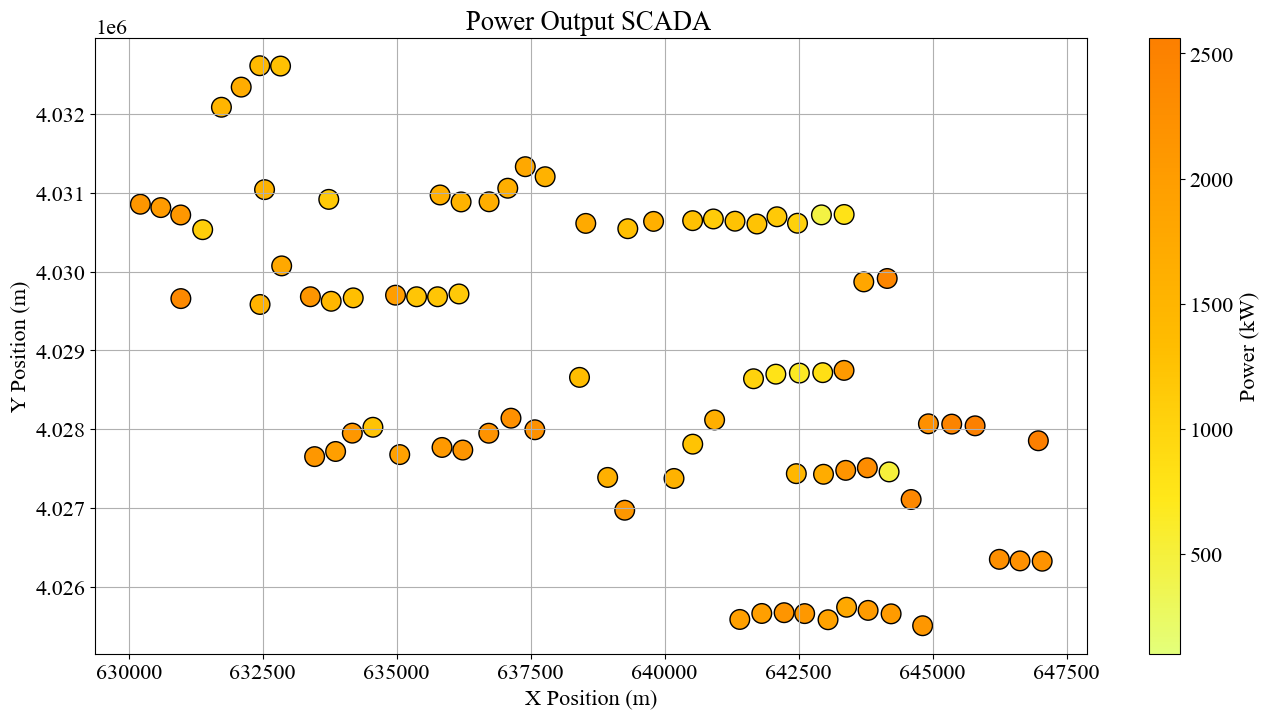

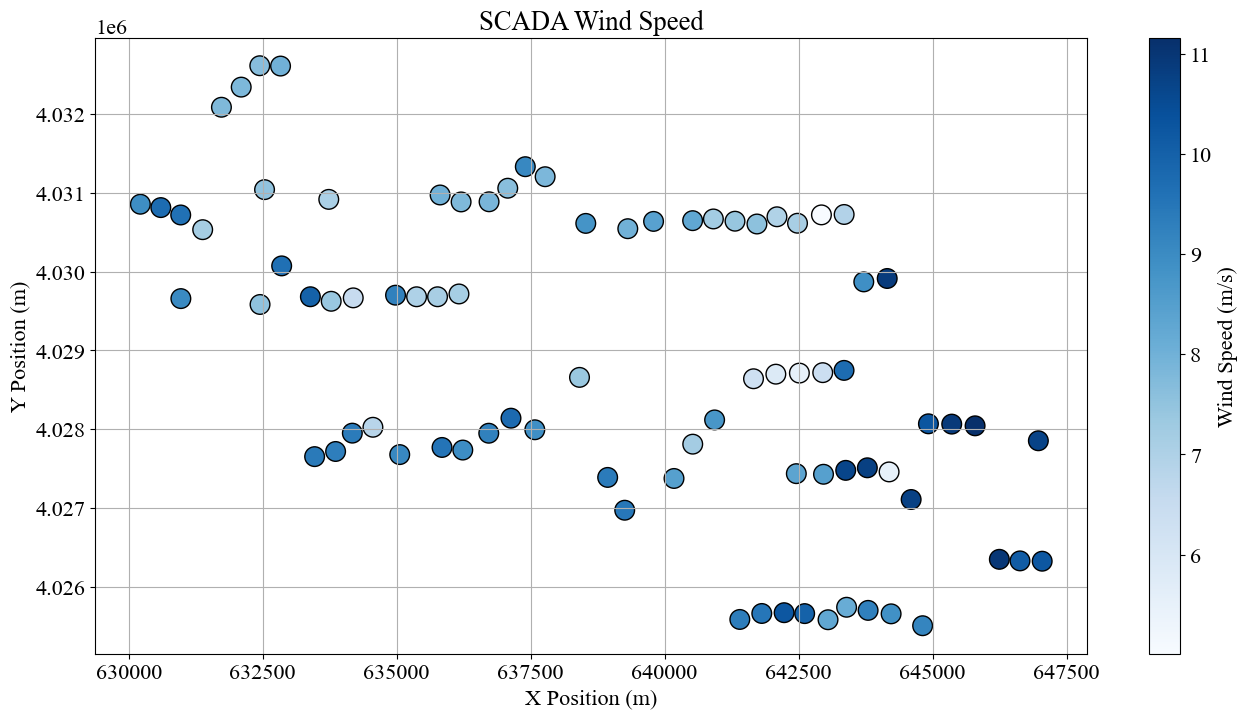

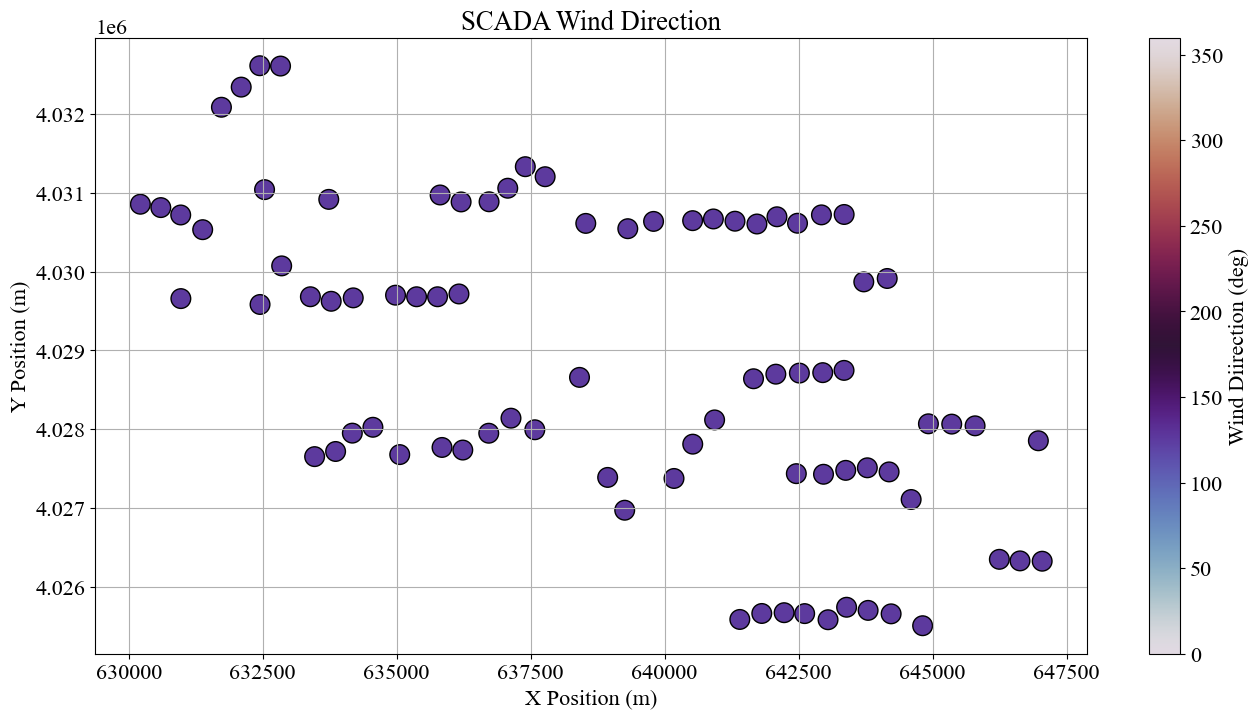

Wind Speed 8.51808531187414, Wind Direction: 126.13707858395107


In [65]:
file_path = '/Users/fbasa/Library/CloudStorage/OneDrive-JohnsHopkins/Energy Meteorology/Project/KingPlainsData/turbines_with_specs.csv'
turbine_df = pd.read_csv(file_path)

turbine_names = turbine_df['# name'][0:88]


# Example turbine locations (separate latitude and longitude columns)
layout_x = turbine_df[' x'][0:88]  # Latitude values

 
layout_y = turbine_df[' y'][0:88]  # Longitude values

plt.figure(figsize=(16, 8))
SCADAscatter = plt.scatter(layout_x,layout_y, c=power_at_time, cmap='Wistia', s=200, edgecolors='k', vmin=100, vmax=np.max(power_at_time))

# Add a colorbar
plt.colorbar(SCADAscatter, label='Power (kW)')
# Add titles and labels
plt.title(f'Power Output SCADA ')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 8))
wind = plt.scatter(layout_x,layout_y, c=speed_at_time, cmap='Blues', s=200, edgecolors='k', vmin=np.min(speed_at_time), vmax=np.max(speed_at_time))

# Add a colorbar
plt.colorbar(wind, label='Wind Speed (m/s)')
# Add titles and labels
plt.title(f'SCADA Wind Speed')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 8))
direction = plt.scatter(layout_x,layout_y, c=direction_at_time, cmap='twilight', s=200, edgecolors='k', vmin=0, vmax=360)

# Add a colorbar
plt.colorbar(direction, label='Wind Diirection (deg)')
# Add titles and labels
plt.title(f'SCADA Wind Direction')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.grid(True)
plt.show()

print(f"Wind Speed {np.mean(speed_at_time).values}, Wind Direction: {np.mean(direction_at_time).values}")



In [66]:
A1_sonic_data = A1_sonic.sel(time=time_of_interest,method='nearest')
A2_sonic_data = A2_sonic.sel(time=time_of_interest,method='nearest')
A5_sonic_data = A5_sonic.sel(time=time_of_interest,method='nearest')


# List of your selected datasets
datasets = [A1_sonic_data, A2_sonic_data, A5_sonic_data]
names = ['A1_sonic', 'A2_sonic', 'A5_sonic']

# Prepare a table
rows = []
for name, ds in zip(names, datasets):
    # ds is a scalar Dataset (single time), convert to dict
    row = {var: ds[var].values.item() for var in ds.data_vars}  # extract scalar values
    row['sonic'] = name
    row['time'] = pd.Timestamp(ds['time'].values)
    rows.append(row)

# Convert to DataFrame
table = pd.DataFrame(rows)

# Optional: reorder columns
cols = ['sonic', 'time'] + [c for c in table.columns if c not in ['sonic','time']]
table = table[cols]

print(table)



      sonic                time     WS     WD       u       v        w    T_s  \
0  A1_sonic 2023-08-24 03:15:00  1.679  117.9  0.7710  1.4580  0.04064  306.5   
1  A2_sonic 2023-08-24 03:15:00  1.756  154.4  1.5650  0.7511 -0.02323  306.2   
2  A5_sonic 2023-08-24 03:15:00  2.009  116.9  0.9016  1.7800  0.06210  305.8   

     F_s       u_*       TKE         L  
0 -16.43  0.142127  0.126630  15.69780  
1 -11.20  0.107471  0.089265   9.96199  
2 -16.72  0.139284  0.089565  14.51740  


Let's check velocity profiles for inflow in Armadilo Flats and King Plains

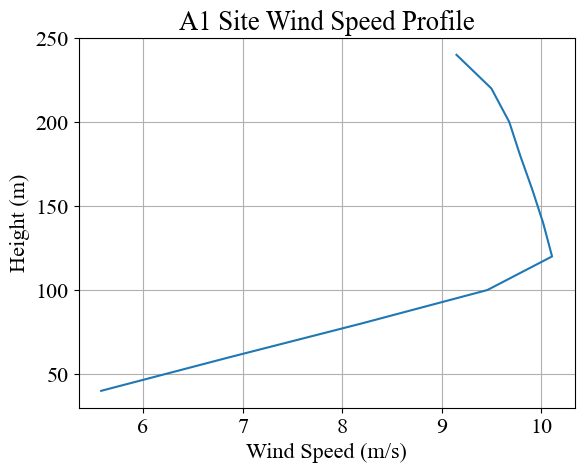

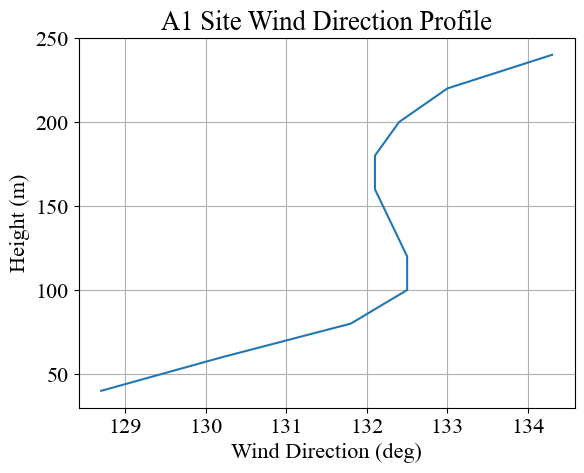

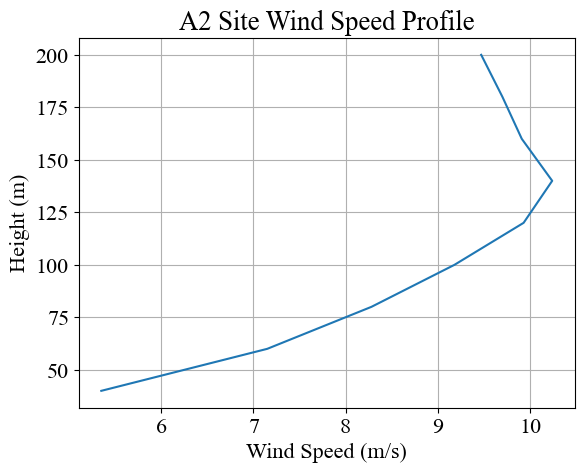

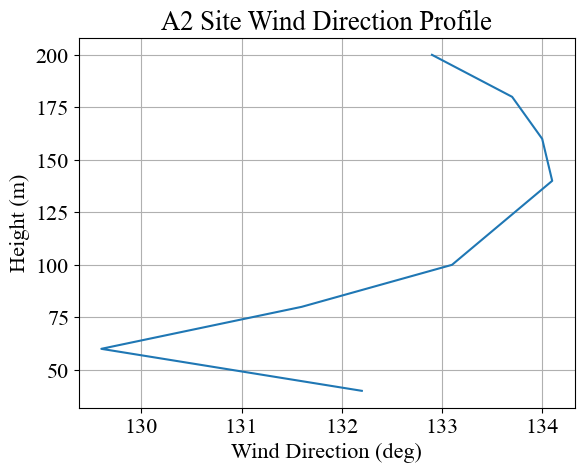

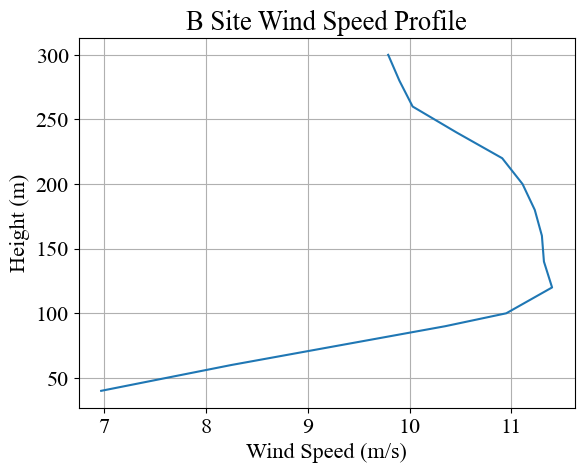

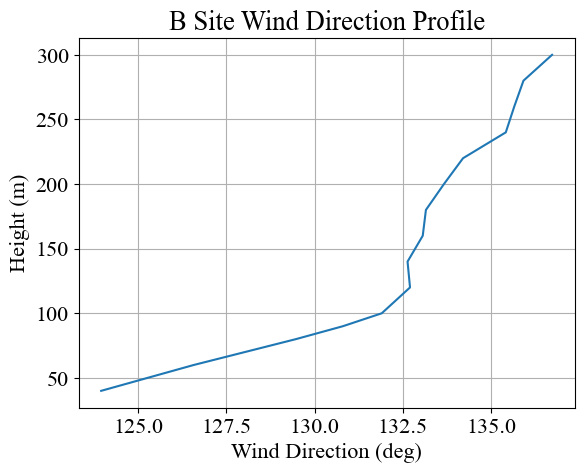

In [67]:
plt.plot(A1_profile_data['U'],A1_profile_data['height'])
plt.title('A1 Site Wind Speed Profile')
plt.ylabel('Height (m)')
plt.xlabel('Wind Speed (m/s)')
plt.grid(True)
plt.show()

plt.plot(A1_profile_data['WD'],A1_profile_data['height'])
plt.title('A1 Site Wind Direction Profile')
plt.ylabel('Height (m)')
plt.xlabel('Wind Direction (deg)')
plt.grid(True)
plt.show()

plt.plot(A2_profile_data['U'],A2_profile_data['height'])
plt.title('A2 Site Wind Speed Profile')
plt.ylabel('Height (m)')
plt.xlabel('Wind Speed (m/s)')
plt.grid(True)
plt.show()
plt.plot(A2_profile_data['WD'],A2_profile_data['height'])
plt.title('A2 Site Wind Direction Profile')
plt.ylabel('Height (m)')
plt.xlabel('Wind Direction (deg)')
plt.grid(True)
plt.show()

plt.plot(B_profile_data['WS'],B_profile_data['height'])
plt.title('B Site Wind Speed Profile')
plt.ylabel('Height (m)')
plt.xlabel('Wind Speed (m/s)')
plt.grid(True)
plt.show()
plt.plot(B_profile_data['WD'],B_profile_data['height'])
plt.title('B Site Wind Direction Profile')
plt.ylabel('Height (m)')
plt.xlabel('Wind Direction (deg)')
plt.grid(True)
plt.show()

In [68]:
A1_scanning_data = A1Scanning.sel(time=time_of_interest,method='nearest')
A2_scanning_data = A2Scanning.sel(time=time_of_interest,method='nearest')
E36_scanning_data = E36Scanning.sel(time=time_of_interest,method='nearest')


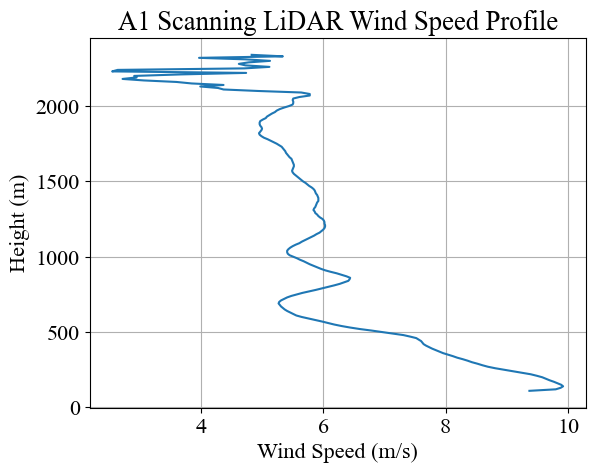

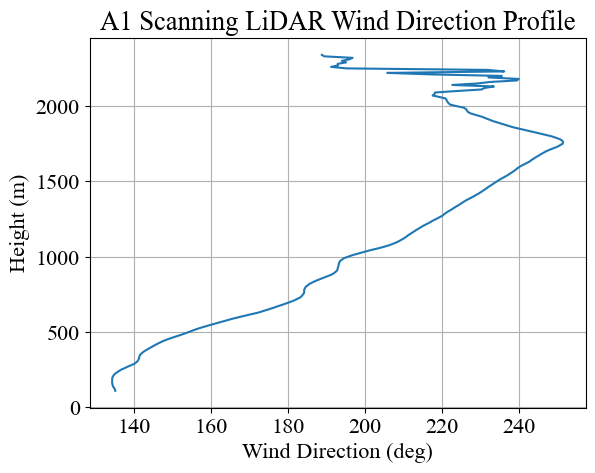

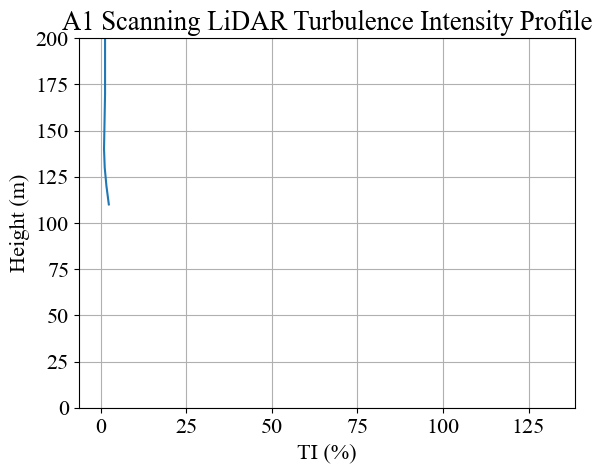

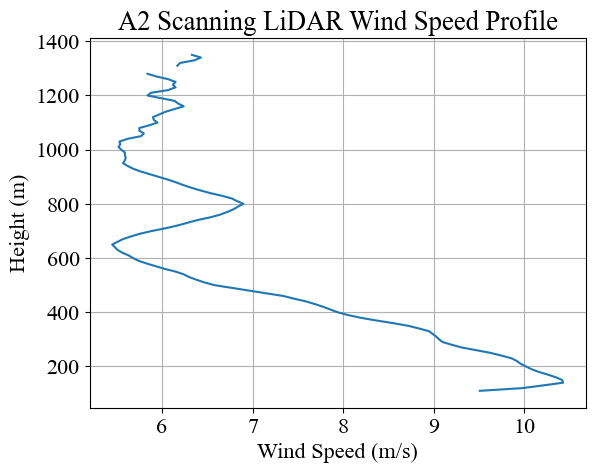

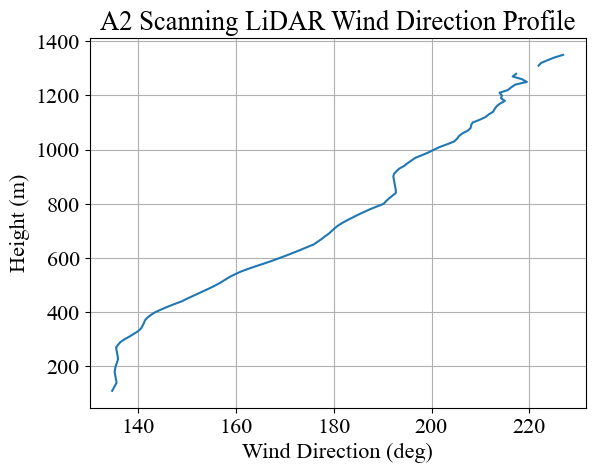

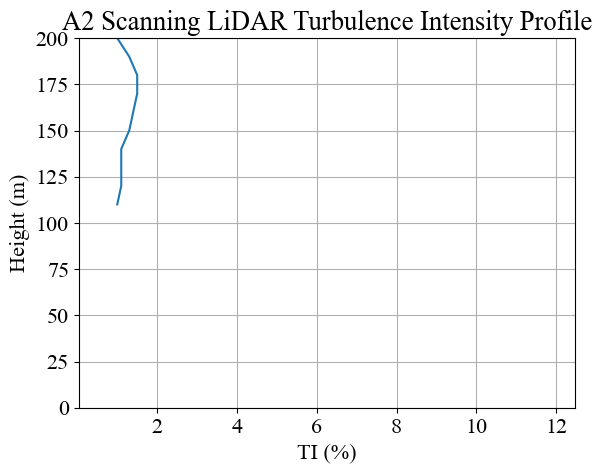

In [69]:
plt.plot(A1_scanning_data['WS'],A1_scanning_data['height'])
plt.title('A1 Scanning LiDAR Wind Speed Profile')
plt.ylabel('Height (m)')
plt.xlabel('Wind Speed (m/s)')
plt.grid(True)
plt.show()

plt.plot(A1_scanning_data['WD'],A1_scanning_data['height'])
plt.title('A1 Scanning LiDAR Wind Direction Profile')
plt.ylabel('Height (m)')
plt.xlabel('Wind Direction (deg)')
plt.grid(True)
plt.show()

plt.plot(A1_scanning_data['TI'],A1_scanning_data['height'])
plt.title('A1 Scanning LiDAR Turbulence Intensity Profile')
plt.ylabel('Height (m)')
plt.xlabel('TI (%)')
plt.ylim(0,200)
plt.grid(True)
plt.show()

plt.plot(A2_scanning_data['WS'],A2_scanning_data['height'])
plt.title('A2 Scanning LiDAR Wind Speed Profile')
plt.ylabel('Height (m)')
plt.xlabel('Wind Speed (m/s)')
plt.grid(True)
plt.show()

plt.plot(A2_scanning_data['WD'],A2_scanning_data['height'])
plt.title('A2 Scanning LiDAR Wind Direction Profile')
plt.ylabel('Height (m)')
plt.xlabel('Wind Direction (deg)')
plt.grid(True)
plt.show()

plt.plot(A2_scanning_data['TI'],A2_scanning_data['height'])
plt.title('A2 Scanning LiDAR Turbulence Intensity Profile')
plt.ylabel('Height (m)')
plt.xlabel('TI (%)')
plt.ylim(0,200)
plt.grid(True)
plt.show()


## Inflow conditions at hub height

In [70]:
import numpy as np
def find_alpha(U,Z,U_ref,Z_ref):


    # Fit using linear regression in log-log space
    mask = np.isfinite(U) & (U > 0)  # remove NaNs
    z = Z[mask]
    u = U[mask]

    alpha = np.polyfit(np.log(z / Z_ref), np.log(u / U_ref), 1)[0]

    print(f"Fitted shear exponent α = {alpha:.3f}")
    return alpha

In [71]:
alphaA1 = find_alpha(A1_profile_data['U'].values,A1_profile_data['height'].values,A1_profile_data['U'].sel(height=40).values.item(),40)
z_hub = 90  # hub height in meters
U_hubA1 = A1_profile_data['U'].sel(height=40) * (z_hub / 40)**alphaA1
print(f"Interpolated wind speed at hub height A1: {U_hubA1:.2f} m/s")
alphaA2 = find_alpha(A2_profile_data['U'].values,A2_profile_data['height'].values,A2_profile_data['U'].sel(height=40).values.item(),40)
z_hub = 90  # hub height in meters
U_hubA2 = A2_profile_data['U'].sel(height=40) * (z_hub / 40)**alphaA2
print(f"Interpolated wind speed at hub height A2: {U_hubA2:.2f} m/s")



Fitted shear exponent α = 0.279
Interpolated wind speed at hub height A1: 6.99 m/s
Fitted shear exponent α = 0.358
Interpolated wind speed at hub height A2: 7.15 m/s


In [72]:

A1_hubheight = (A1_profile_data.sel(height=80,method='nearest')+A1_profile_data.sel(height=100,method='nearest'))/2
A2_hubheight = (A2_profile_data.sel(height=80,method='nearest')+A2_profile_data.sel(height=100,method='nearest'))/2
B_hubheight = B_profile_data.sel(height=88.5,method='nearest')
E36_hubheight = E36Scanning.sel(height=88.5,time=time_of_interest,method='nearest')

print(f"A1 WS: {A1_hubheight['U'].values}, WD: {A1_hubheight['WD'].values}")
print(f"A2 WS: {A2_hubheight['U'].values}, WD: {A2_hubheight['WD'].values}")
print(f"B WS: {B_hubheight['WS'].values}, WD: {B_hubheight['WD'].values}")
print(f"E36 WS: {E36_hubheight['WS'].values}, WD: {E36_hubheight['WD'].values}")



A1 WS: 8.825, WD: 132.15
A2 WS: 8.73, WD: 132.35
B WS: 10.35, WD: 130.8
E36 WS: 10.621267318725586, WD: 134.8583526611328


In [73]:
A1_sonic_data = A1_sonic.sel(time=time_of_interest,method='nearest')
A2_sonic_data = A2_sonic.sel(time=time_of_interest,method='nearest')
# List of your selected datasets
datasets = [A1_sonic_data, A2_sonic_data]
names = ['A1 Sonic Anem.', 'A2 Sonic Anem']

# Prepare a table
rows = []
for name, ds in zip(names, datasets):
    # ds is a scalar Dataset (single time), convert to dict
    row = {var: ds[var].values.item() for var in ds.data_vars}  # extract scalar values
    row['Scan'] = name
    rows.append(row)

# Convert to DataFrame
table = pd.DataFrame(rows)

# Optional: reorder columns
cols = ['Scan'] + [c for c in table.columns if c not in ['Scan']]
table = table[cols]

print(table)




             Scan     WS     WD      u       v        w    T_s    F_s  \
0  A1 Sonic Anem.  1.679  117.9  0.771  1.4580  0.04064  306.5 -16.43   
1   A2 Sonic Anem  1.756  154.4  1.565  0.7511 -0.02323  306.2 -11.20   

        u_*       TKE         L  
0  0.142127  0.126630  15.69780  
1  0.107471  0.089265   9.96199  


In [74]:

datasets = [A1_scanning_data.sel(height=110,method='nearest'), A2_scanning_data.sel(height=110,method='nearest')]
names = ['A1 Scanning LiDAR', 'A2 Scanning LiDAR']

# Prepare a table
rows = []
for name, ds in zip(names, datasets):
    # ds is a scalar Dataset (single time), convert to dict
    row = {var: ds[var].values.item() for var in ds.data_vars}  # extract scalar values
    row['Scan'] = name
    rows.append(row)

# Convert to DataFrame
table = pd.DataFrame(rows)

# Optional: reorder columns
cols = ['Scan'] + [c for c in table.columns if c not in ['Scan']]
table = table[cols]

print(table)




                Scan           time_start             time_end    WS     WD  \
0  A1 Scanning LiDAR  1692846000000000000  1692846600000000000  9.37  135.0   
1  A2 Scanning LiDAR  1692846000000000000  1692846600000000000  9.51  134.7   

      u     v     w   TI    TKE  
0 -6.63  6.62  0.19  2.4  0.063  
1 -6.77  6.69 -0.17  1.0  0.016  
